In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

import gc

In [332]:
import warnings 
warnings.filterwarnings('ignore')

# speech embedding

In [2]:
with open('filtered_speeches.pkl', 'rb') as f:
    df_f = pickle.load(f)

## sentence-transformers

designed to generate semantically meaningful embeddings for sentences

easier embedding implementation - all transformers have small max seq length

In [4]:
# "hon." confuses sentencizer - leads to false positive sentence endings
df_f['speech'] = df_f['speech'].str.replace('hon.', 'hon')

<ipython-input-4-88bba1693dc4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_f['speech'] = df_f['speech'].str.replace('hon.', 'hon')


In [23]:
nlp = spacy.load('en_core_web_sm')

df_f['sents'] = pd.Series([], dtype='object')

for i, doc in enumerate( nlp.pipe(df_f.speech, n_process=15, batch_size=100) ):
    df_f.at[df_f.index[i], 'sents'] = [str(sent) for sent in doc.sents]
    
    if (i+1) % 1000 == 0:
        print(i+1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


run when loading

In [2]:
# with open('filtered_speeches_sent.pkl', 'wb') as f:
#     pickle.dump(df_f, f)

with open('filtered_speeches_sent.pkl', 'rb') as f:
    df_f = pickle.load(f)

### re-form into 1d list of sentences

In [31]:
def flatten(t):
    return [item for sublist in t for item in sublist]

sentences = flatten(df_f.sents.values)

In [38]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

# don't run if loading embeddings
sentence_embeddings = embedder.encode(sentences)
sentence_embeddings = sentence_embeddings /  np.linalg.norm(sentence_embeddings, axis=1, keepdims=True)

run when loading

In [3]:
# don't run if loading embeddings
# with open('sentence_embeddings.pkl', 'wb') as f:
#     pickle.dump(sentence_embeddings, f)

with open('sentence_embeddings.pkl', 'rb') as f:
    sentence_embeddings = pickle.load(f)

In [4]:
sentence_embeddings.shape

(1823996, 384)

## count prop. contributions with word/lemma counts above embedder max input sequence length

#### sentences

max sequence length: 128
wordcounts above 128: 0.0588 %


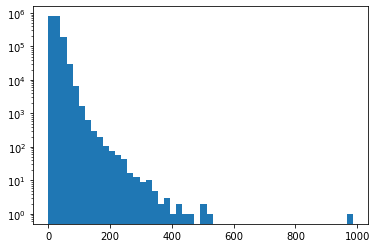

In [53]:
wordcount = np.array(list(map(lambda x: len(x.split()), sentences)))

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

plt.hist(wordcount, bins=50)
plt.yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

In [61]:
for i in np.where(wordcount > 400)[0]:
    print(corpus[i], '\n')

Glasgow SouthPaul Farrelly, Newcastle-under-LymeMartyn Day, Linlithgow and East FalkirkKate Ofunne Osamor, EdmontonPaula Michelle Sherriff, DewsburyNaseem Akhter Shah, Bradford WestNicklaus Thomas-Symonds, TorfaenAndrew Egan Henderson Hendry, Inverness, Nairn, Badenoch and StrathspeyPaul William Monaghan, Caithness, Sutherland and Easter RossCorraine Wilson, Ayr, Carrick and CumnockCarol Monaghan, Glasgow North WestAlan Brown, Kilmarnock and LoudounRonnie Cowan , InverclydeVirendra Kumar Sharma, Ealing, SouthallPatricia Gibson, North Ayrshire and ArranThomas Beatty Elliott, Fermanagh and South TyroneSarah Deborah Champion, RotherhamHelen Elizabeth Hayes, Dulwich and West NorwoodVictoria Jane Foxcroft, Lewisham, DeptfordBrendan O’Hara, Argyll and ButeKirsten Frances Oswald, East RenfrewshireMarion Fellows, Motherwell and WishawTasmina Ahmed-Sheikh, Ochil and South PerthshireMark Andrew Pritchard, The WrekinChristopher John Pincher, TamworthNadhim Zahawi, Stratford-on-AvonMarie Elizabeth

#### speeches & lemmas

max sequence length: 128
wordcounts above 128: 92.8103 %
lemmacounts above 128: 65.139 %


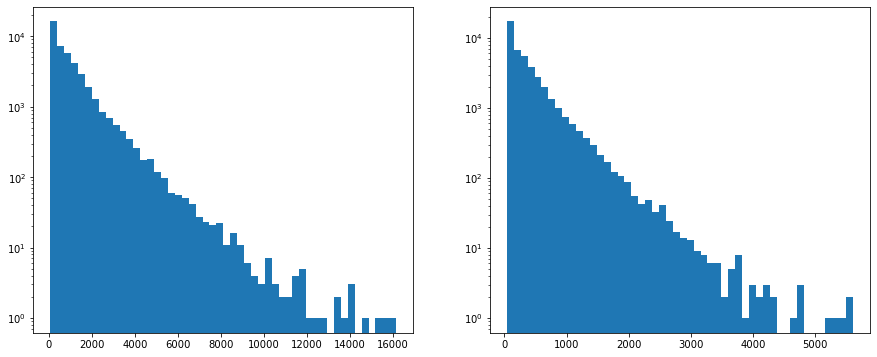

In [62]:
wordcount = df_f.speech.apply(lambda x: len(x.split())).values
lemmacount = df_f.lemmas_ngrams.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

## aggregate sentence embeddings

In [66]:
# check that the total number of sentences is equal to the combined length of all of the lists in the 'sents' column (lists of sentences)
sents_per_speech = df_f.sents.apply(len).values
np.sum(sents_per_speech) == len(sentences)

True

In [95]:
# each sentence is given a speech id - sentences originating from the same speech have the same id
groups = np.array(flatten([[i] * sents_per_speech[i] for i in range(len(df_f))]))
groups

array([    0,     0,     0, ..., 43770, 43770, 43770])

In [97]:
# use sentence speech ids to average sentence vectors to speech vectors
corpus_embeddings = []
for group in np.unique(groups):
    corpus_embeddings.append(np.mean(sentence_embeddings[groups == group], axis=0))
corpus_embeddings = np.array(corpus_embeddings)

In [98]:
speech_vecs.shape

(43771, 384)

run when loading

In [4]:
# # don't run if loading embeddings
# with open('agg_sentence_embeddings.pkl', 'wb') as f:
#     pickle.dump(corpus_embeddings, f)

with open('agg_sentence_embeddings.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [6]:
corpus_embeddings.shape

(43771, 384)

run all below when loading

## PCA dimensionality reduction

In [6]:
from sklearn.decomposition import PCA

np.random.seed(26)

pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

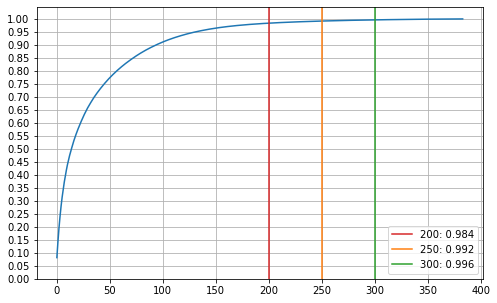

In [7]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,401,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 200
ax.axvline(v, c='tab:red', label=f'{v}: {str(np.around(cum_evr[v], 3))}')

v = 250
ax.axvline(v, c='tab:orange', label=f'{v}: {str(np.around(cum_evr[v], 3))}')

v = 300
ax.axvline(v, c='tab:green', label=f'{v}: {str(np.around(cum_evr[v], 3))}')

ax.legend()

plt.show()

In [8]:
do_PCA = True

if do_PCA:
    embeddings = PCA(n_components=250, random_state=26).fit_transform(corpus_embeddings)
else:
    embeddings = corpus_embeddings

## umap dimensionality reduction

#### get MP party list

In [9]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)
    
MP_party = df_orig[['display_as', 'party']].copy()
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

del df_orig
gc.collect()

MP_party.head()

party
display_as                      
John Bercow              Speaker
Peter Lilley        Conservative
Donald Foster   Liberal Democrat
Harriet Harman            Labour
David Cameron       Conservative

In [10]:
names = [x[2] for x in df_f.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]
print(np.unique(parties))

party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

['Alliance' 'Conservative' 'Democratic Unionist Party' 'Green Party'
 'Independent' 'Labour' 'Labour (Co-op)' 'Liberal Democrat' 'Plaid Cymru'
 'Respect' 'Scottish National Party' 'Social Democratic & Labour Party'
 'Speaker' 'Ulster Unionist Party']


### do UMAP and plot

colour speeches by party of MP

In [11]:
reducer = umap.UMAP(n_neighbors=10, 
                    min_dist=0,
                    metric='cosine',
                    low_memory=False)
X = reducer.fit_transform(embeddings) # dimension reduced embedding

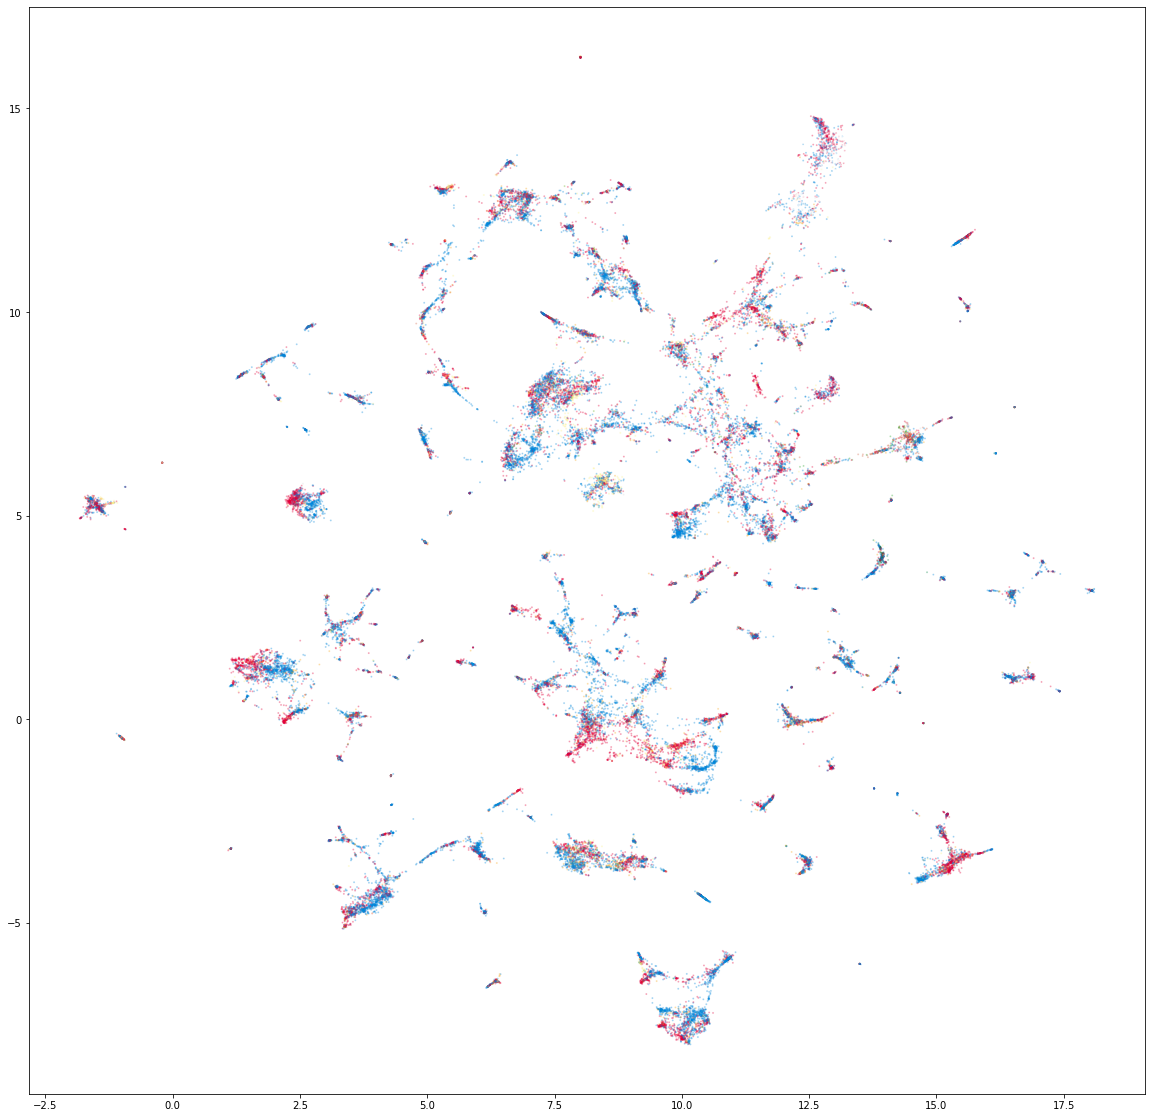

In [12]:
plt.figure(figsize=(20,20))
plt.scatter(X[:,0], X[:,1], s=1, alpha=.25, c=c)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

these parameters tuned manually - for this dataset captures clusters of different sizes and densities well

In [13]:
import hdbscan
from sklearn.metrics import davies_bouldin_score as dbscore

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


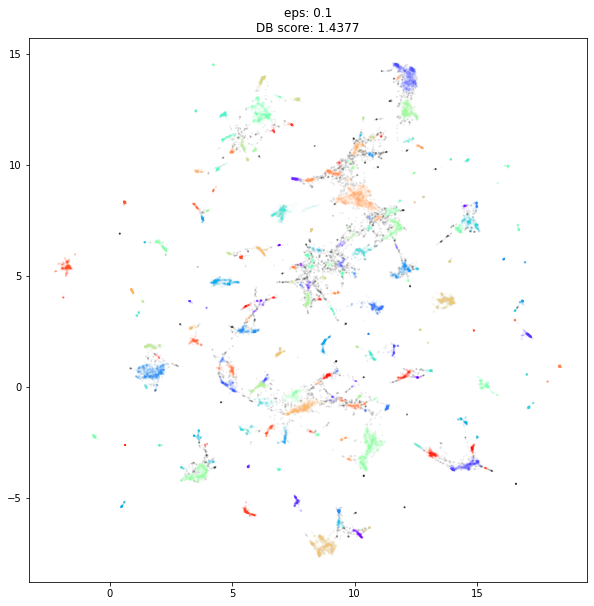

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


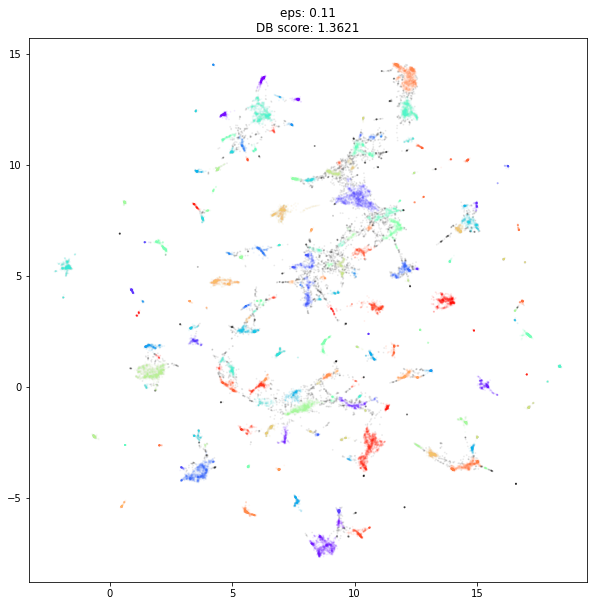

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


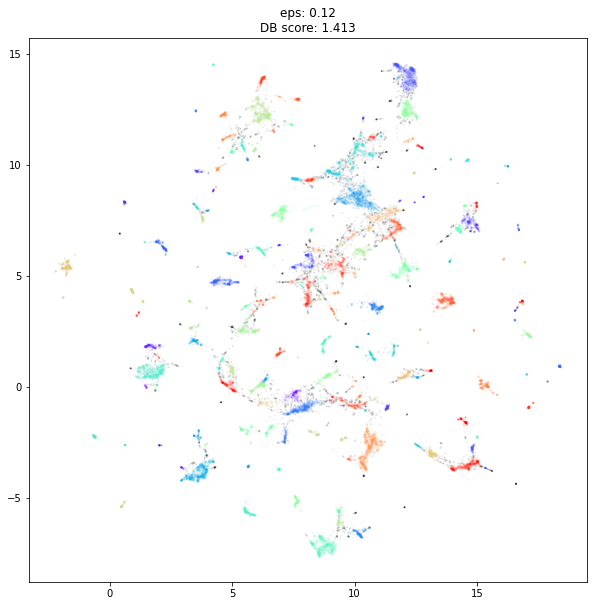

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


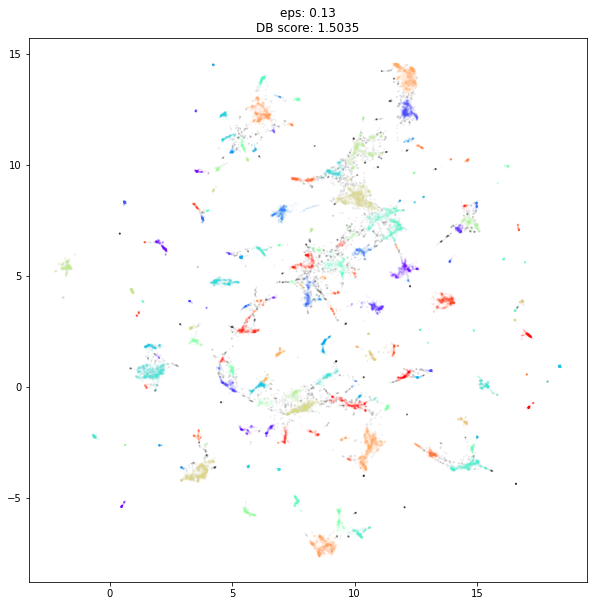

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


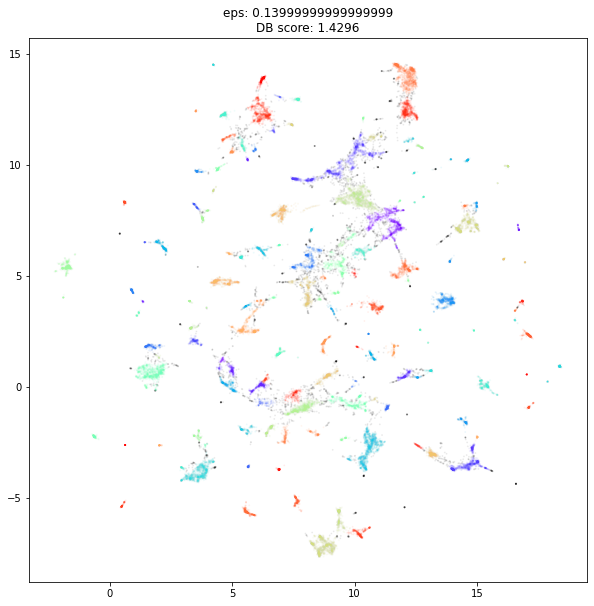

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


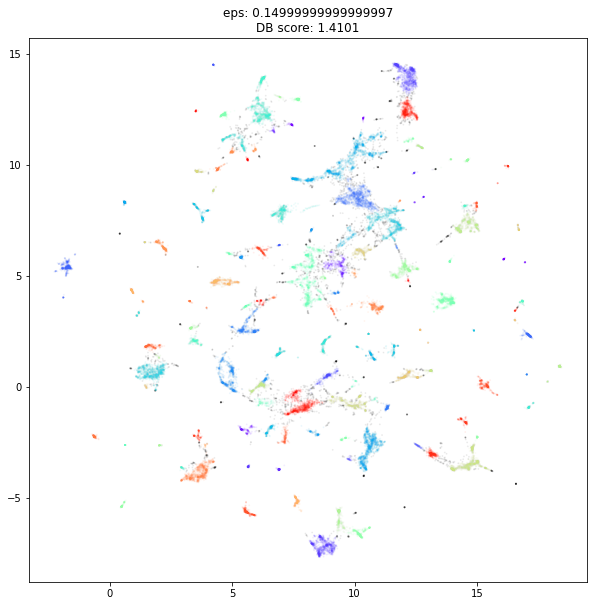

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


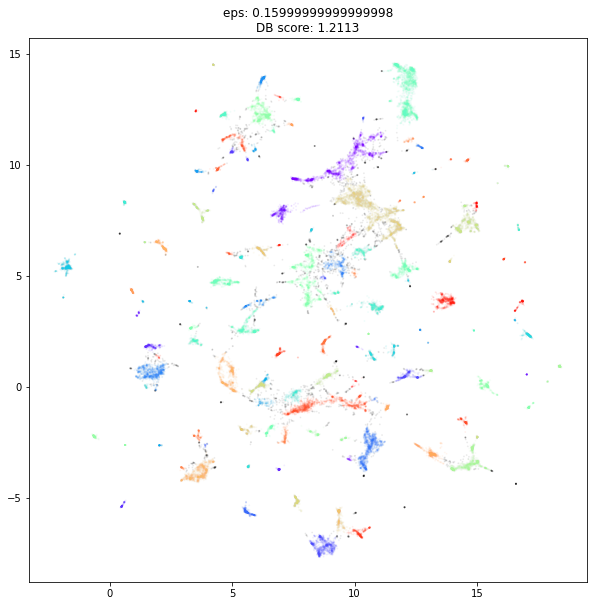

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


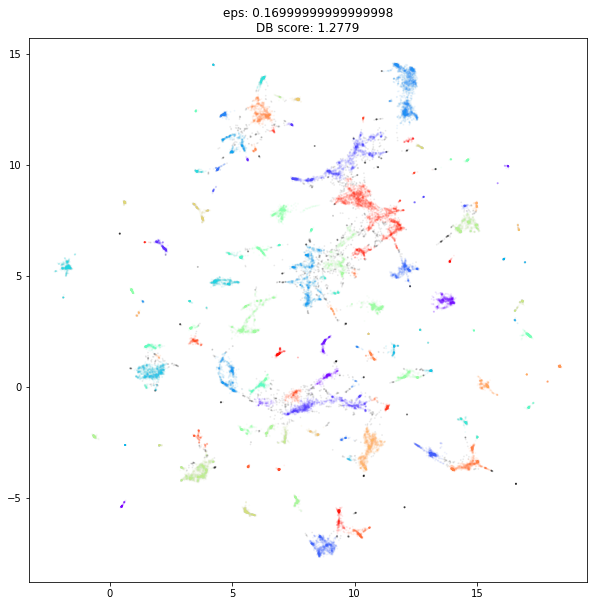

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


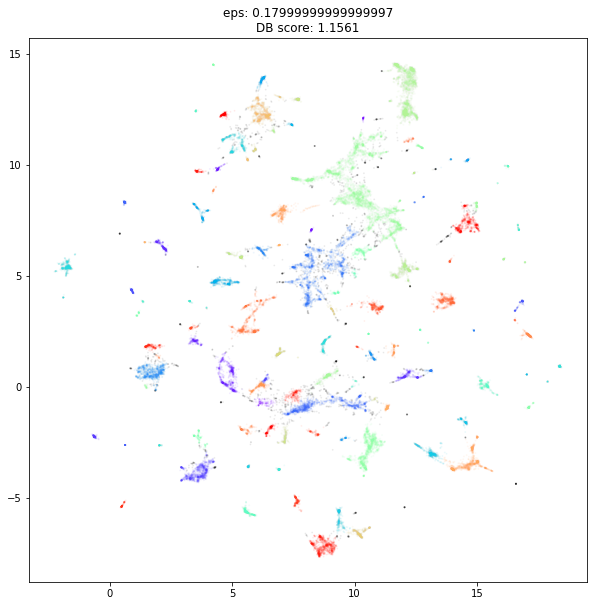

<ipython-input-21-e9cb6477cc44>:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


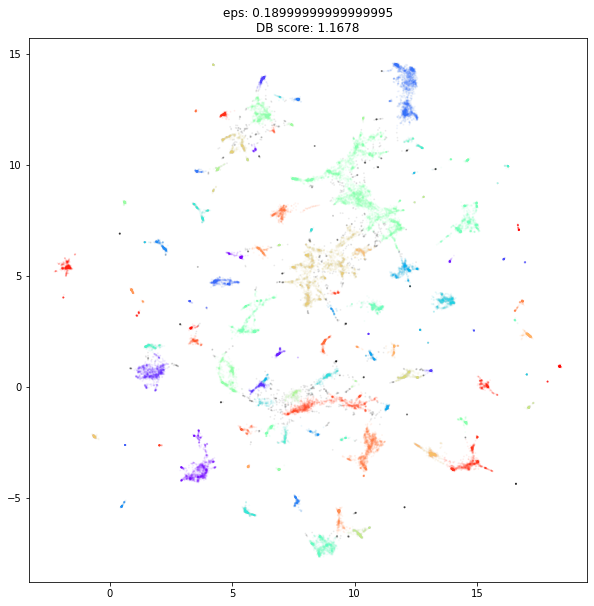

In [21]:
for eps in list(np.arange(0.1,0.2,0.01)):
    
    eps = float(eps)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=30,
                                cluster_selection_epsilon=eps,
                                cluster_selection_method='eom')

    cluster_labels = clusterer.fit_predict(X)

    label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                                 len(np.unique(cluster_labels)) - 1,
                                 replace=False)
    label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
    label_map[-1] = -1

    cluster_labels = np.array([label_map[x] for x in cluster_labels])

    cmap = plt.get_cmap('rainbow')
    cmap.set_under('black')  # Color for values less than vmin

    plt.figure(figsize=(10,10))
    plt.scatter(X[:, 0], X[:, 1], 
                s=1, alpha=.05, c=cluster_labels,
                cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
    # plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
    
    score = dbscore(X, cluster_labels)
    
    plt.title(f'eps: {str(eps)}\nDB score: {str(np.around(score, 4))}')
    plt.show()

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                            min_samples=30,
                            cluster_selection_epsilon=0.16,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

In [15]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-16-44f4aa560430>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


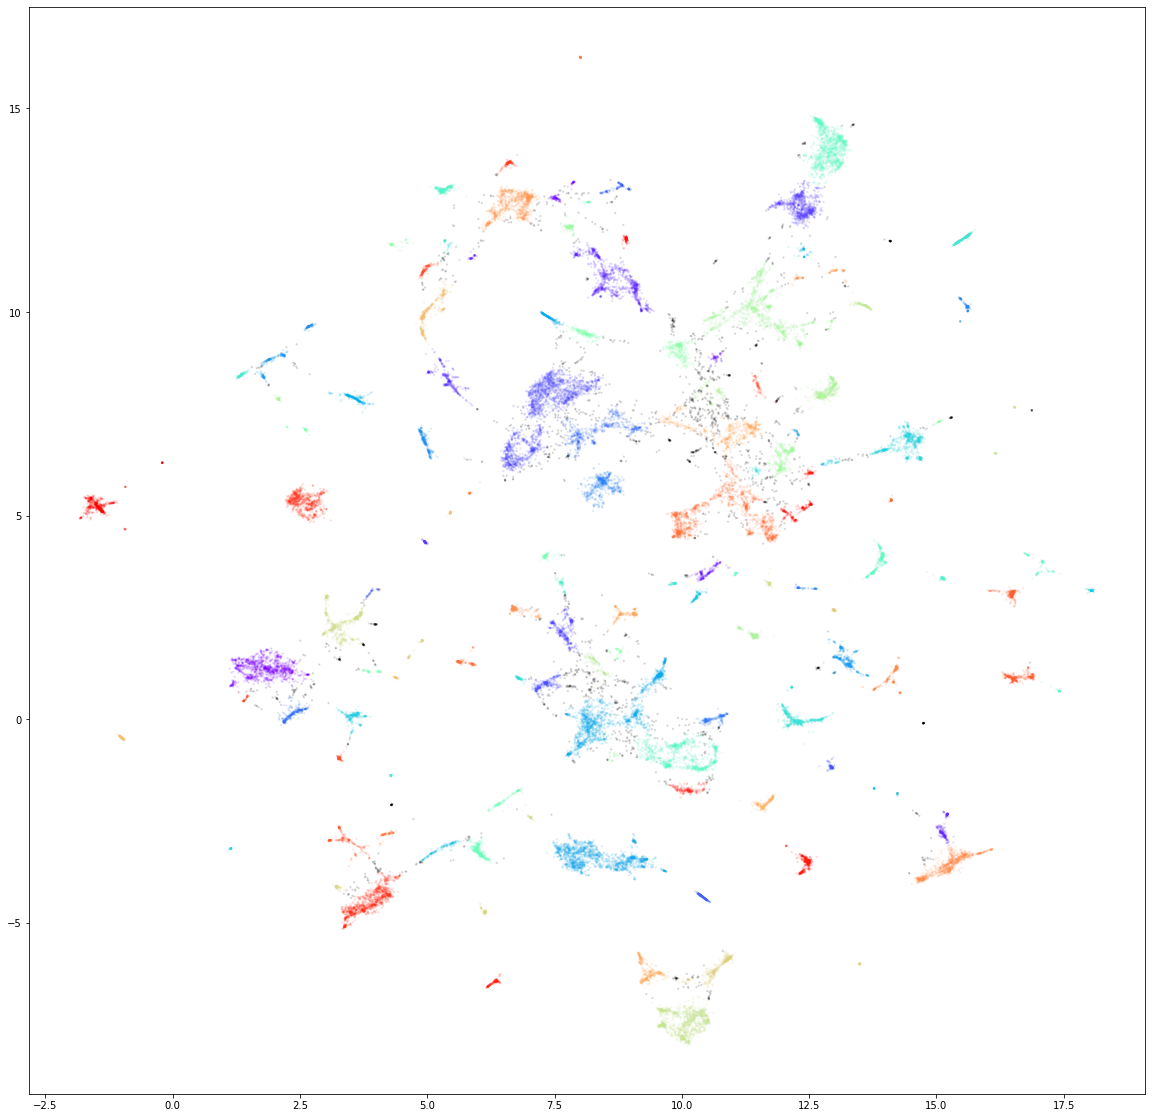

In [16]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(20,20))
plt.scatter(X[:, 0], X[:, 1], 
            s=2, alpha=.1, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

<ipython-input-17-9ee92abf693d>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


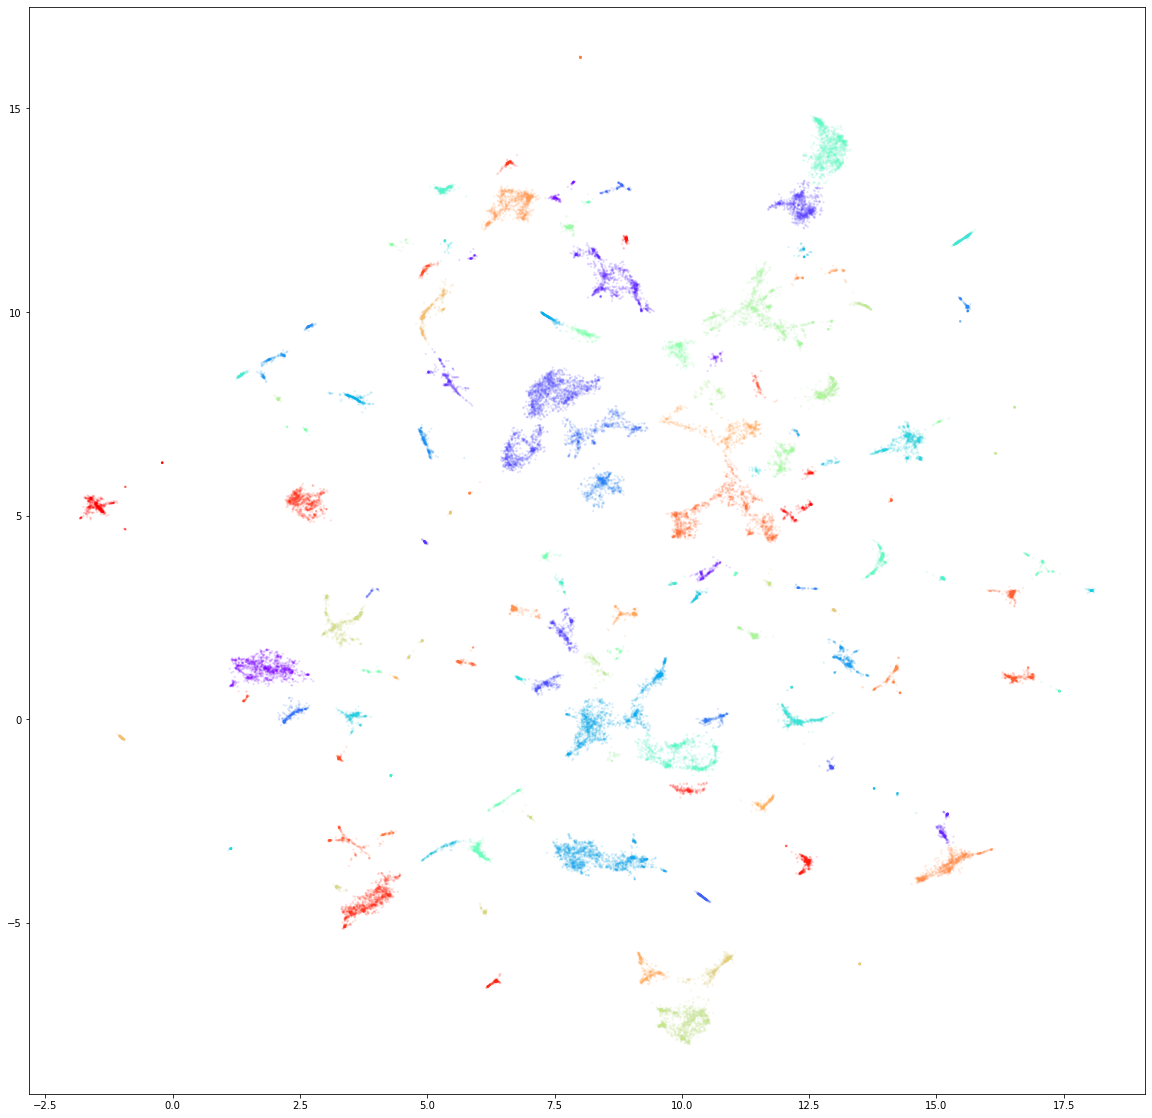

In [17]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(20,20))
plt.scatter(X[(cluster_labels != -1), 0], X[(cluster_labels != -1), 1], 
            s=2, alpha=.1, c=cluster_labels[(cluster_labels != -1)],
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

# ploty: interactive scatter & centroids

In [38]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels
df_proj.head()

0          1  cluster
0  10.292962  12.664304       40
1   7.016636  10.104649       64
2   6.966382   9.771811       -1
3   7.385569   9.890518       64
4   7.497554   9.893916       64

In [148]:
# import plotly.express as px
# fig = px.scatter(df_proj, x=0, y=1, 
#                  opacity=0.2,
#                  color='cluster', hover_data=['cluster'],
#                  height=800, width=1200)
# fig.update_traces(marker=dict(size=2),
#                   selector=dict(mode='markers'))
# fig.write_html("clustered_embeddings.html")
# # fig.show()

# Sub-clusters

leaf clustering:

"If you are more interested in having small homogeneous clusters then you may find Excess of Mass has a tendency to pick one or two large clusters and then a number of small extra clusters. In this situation you may be tempted to recluster just the data in the single large cluster. Instead, a better option is to select 'leaf' as a cluster selection method. This will select leaf nodes from the tree, producing many small homogeneous clusters. Note that you can still get variable density clusters via this method, and it is also still possible to get large clusters, but there will be a tendency to produce a more fine grained clustering than Excess of Mass can provide."

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#leaf-clustering

In [18]:
def sq_area(data):
    x_range = np.max(data[:,0]) - np.min(data[:,0])
    y_range = np.max(data[:,1]) - np.min(data[:,1])
    return x_range * y_range

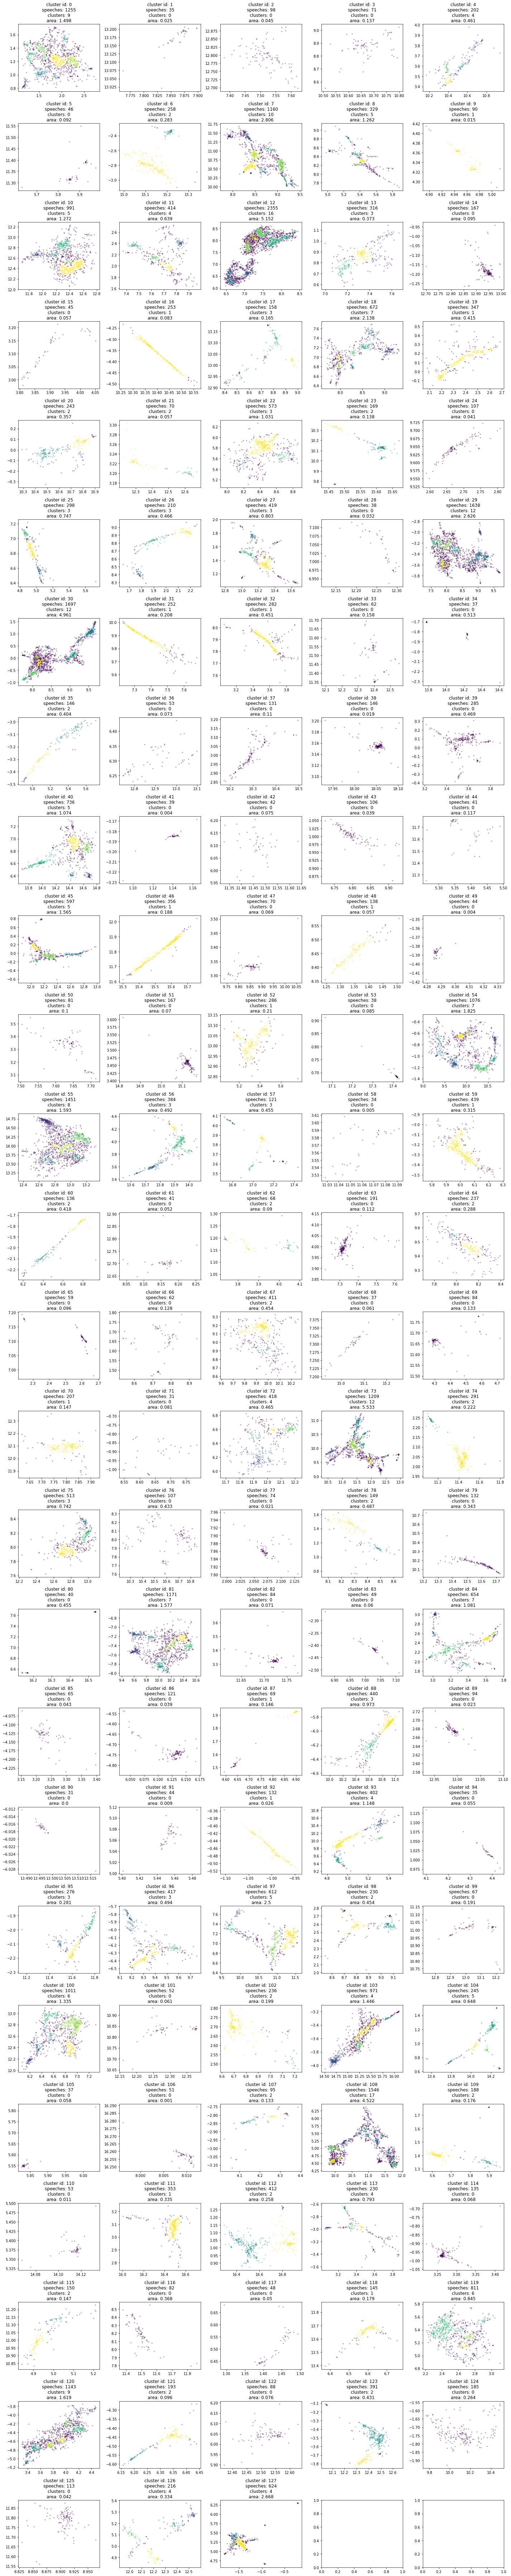

In [19]:
ncols = 5
nrows = int(np.ceil( (len(np.unique(cluster_labels)) - 1) / ncols ))
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 100))

sub_clusters = {}

for i, cluster_id in enumerate(np.arange(len(np.unique(cluster_labels)) - 1)):
    ids = np.where(cluster_labels == cluster_id)[0]
    
    X_cluster = X[ids]
    
    sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                            min_samples=20,
                            cluster_selection_epsilon=0.04,
                            cluster_selection_method='leaf',
                            allow_single_cluster=True)

    sub_cluster_labels = sub_clusterer.fit_predict(X_cluster)
    sub_clusters[cluster_id] = sub_cluster_labels
    
    row = i // ncols
    col = i % ncols
    
    ax[row, col].scatter( X_cluster[:, 0], X_cluster[:, 1],
                   s=5, alpha=0.3, c=sub_cluster_labels)
    ax[row, col].set_title(f'cluster id: {cluster_id}\nspeeches: {len(ids)}\nclusters: {len(np.unique(sub_cluster_labels)) - 1}\narea: {str(np.around(sq_area(X_cluster), 3))}')

plt.tight_layout()
plt.show()

In [75]:
def get_centroids(X, cluster_labels):
    centroids = []
    for i in np.unique(cluster_labels):
        if i != -1:
            centroids.append(np.mean(X[cluster_labels == i], axis=0))
    return np.array(centroids)

61 clusters with >1 cluster (excluding noise)



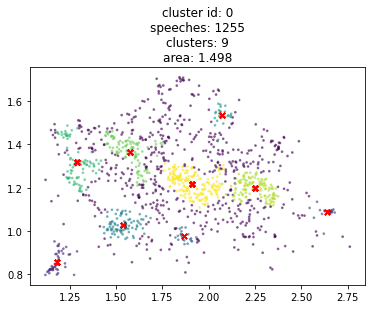

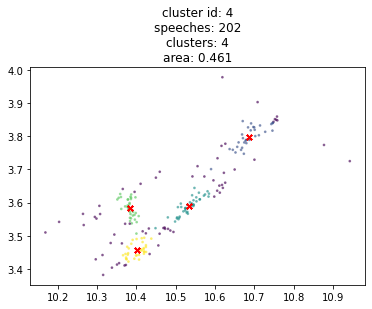

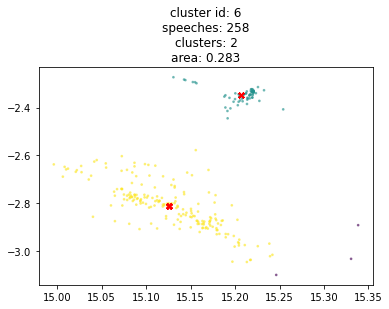

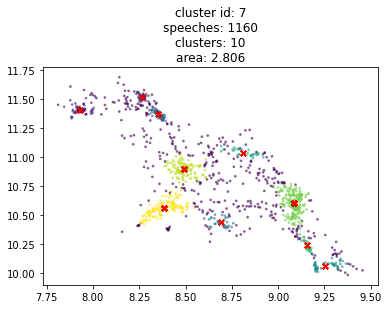

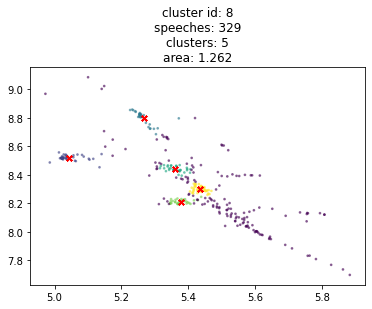

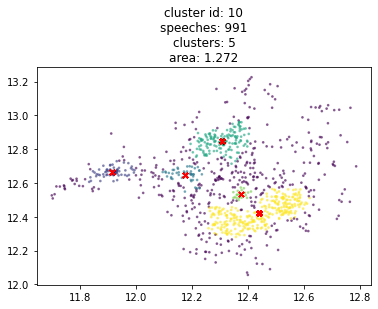

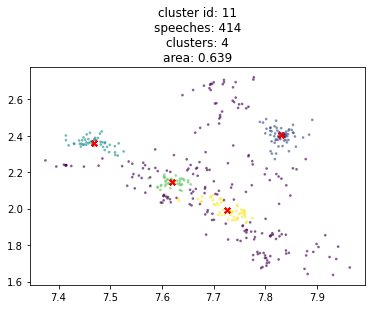

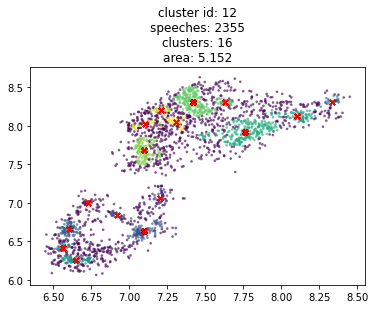

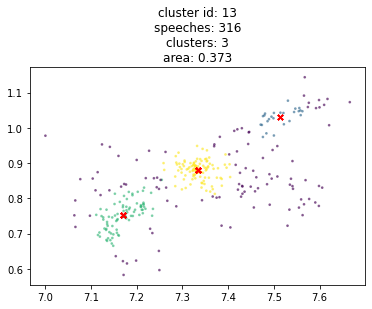

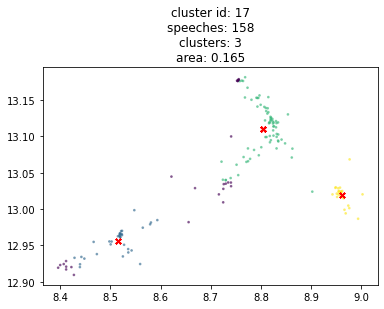

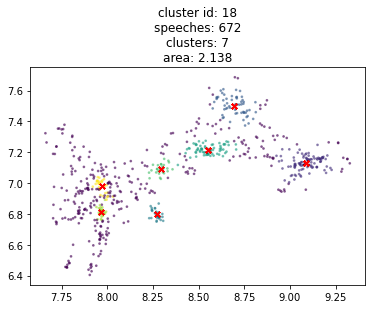

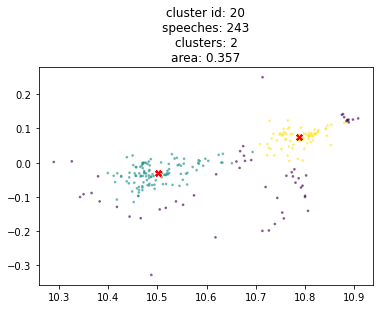

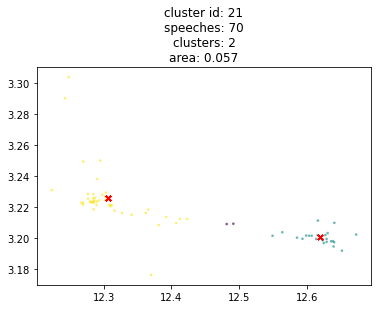

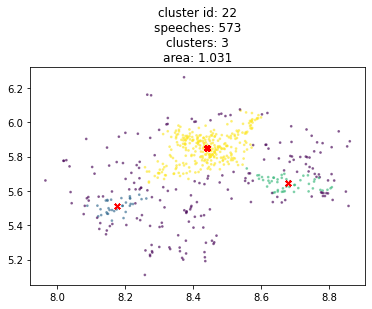

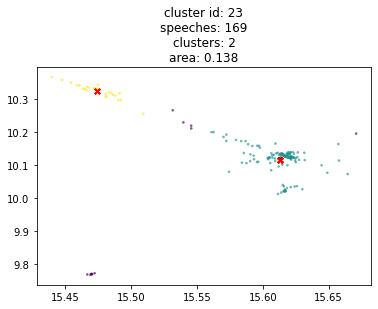

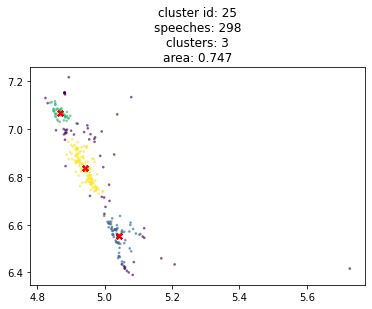

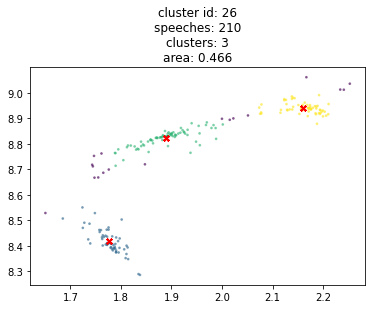

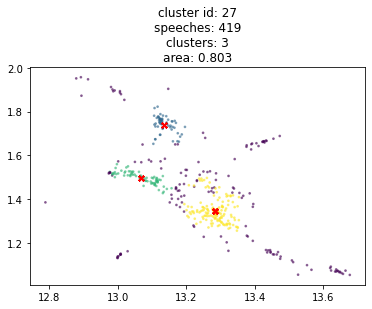

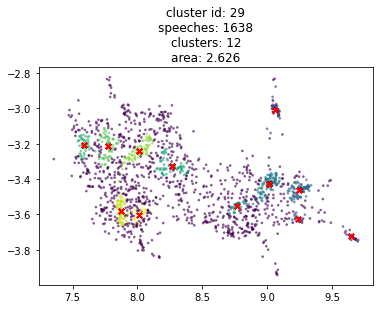

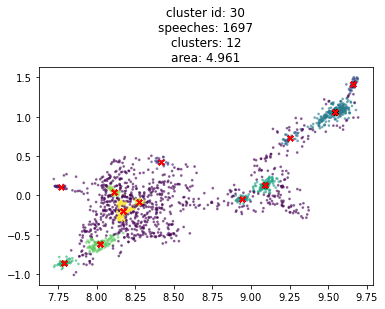

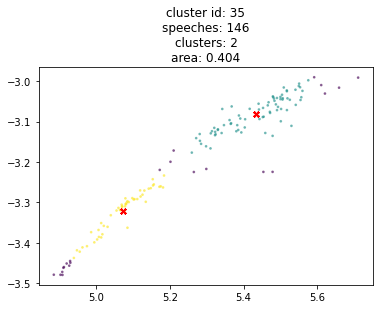

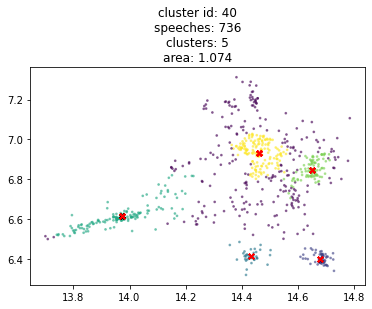

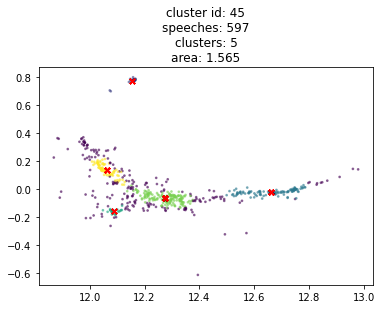

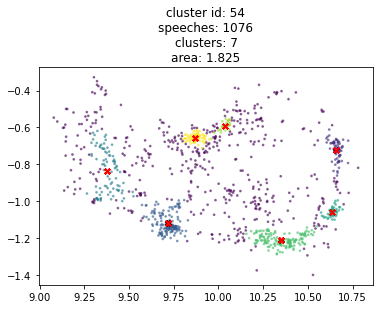

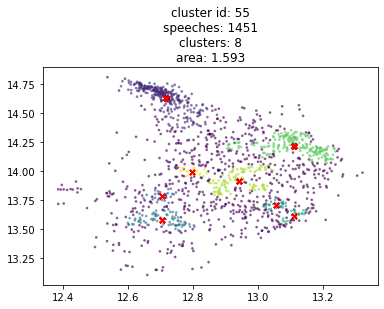

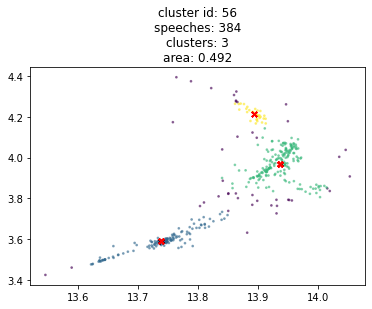

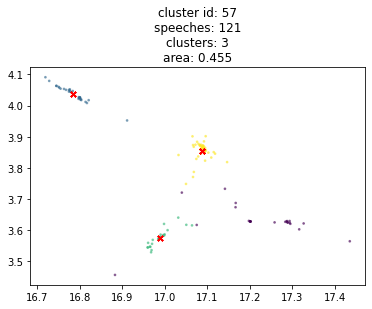

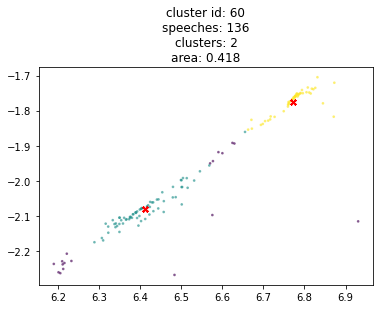

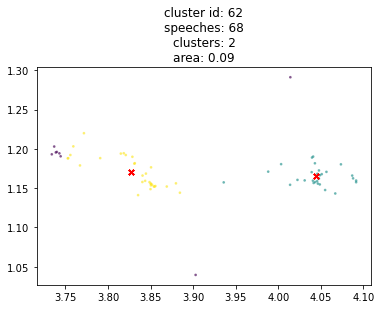

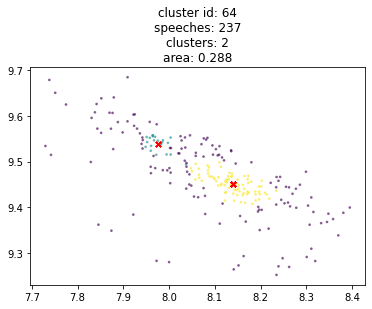

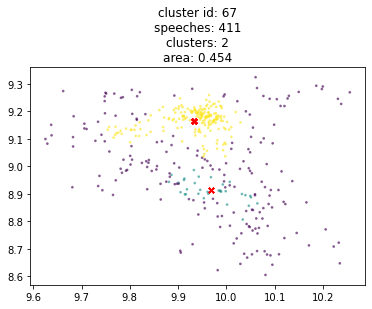

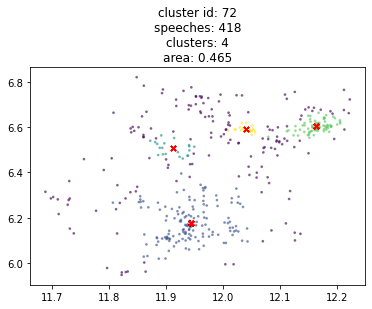

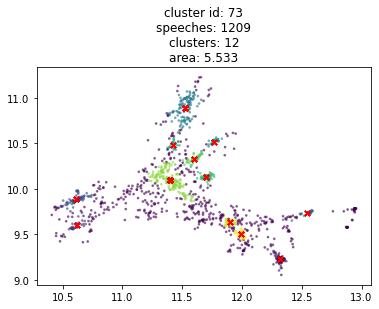

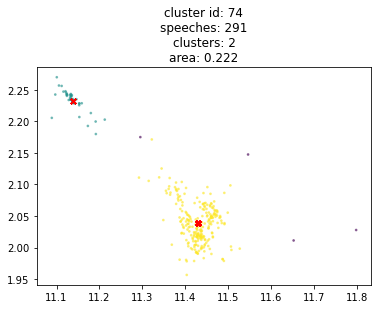

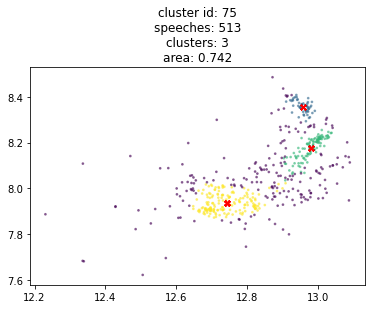

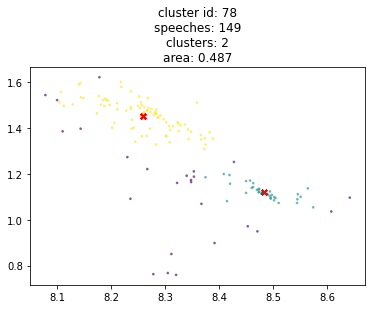

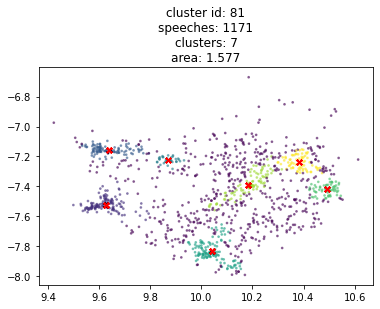

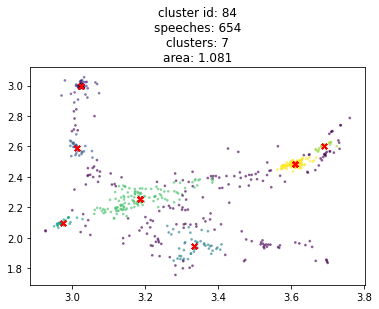

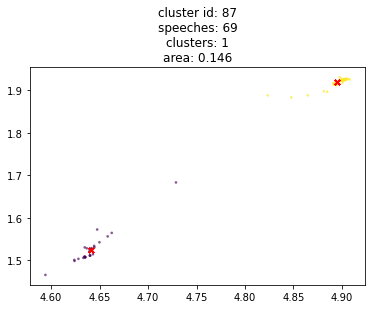

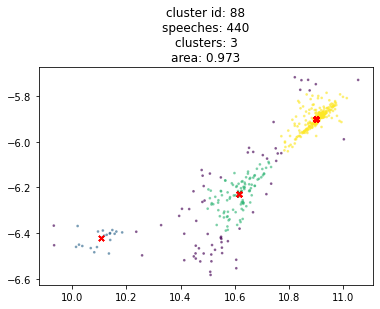

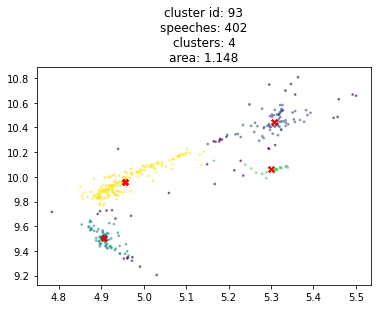

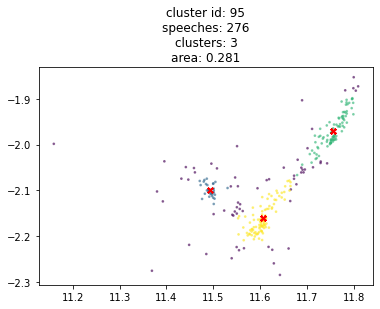

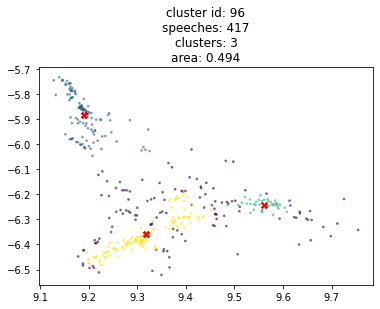

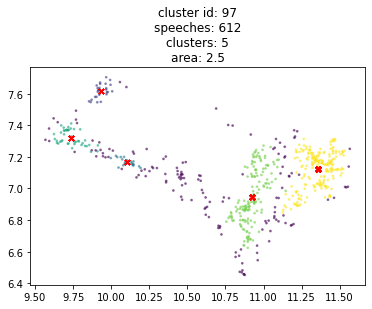

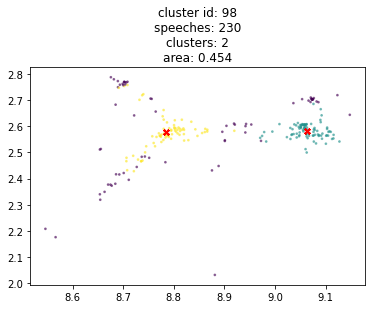

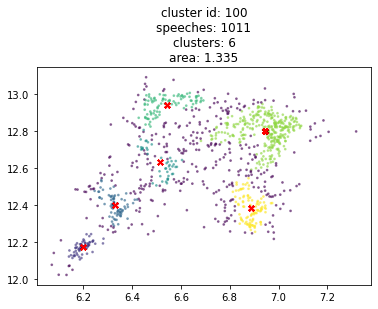

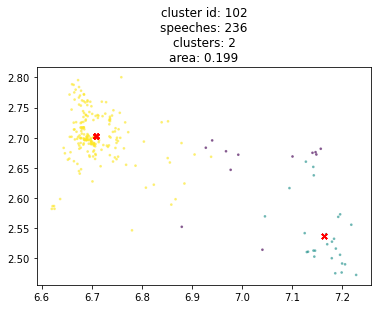

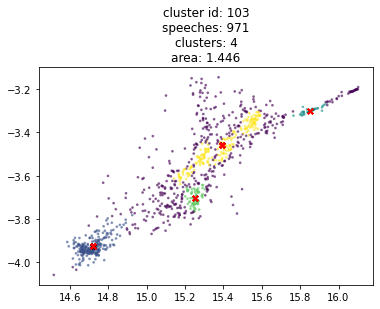

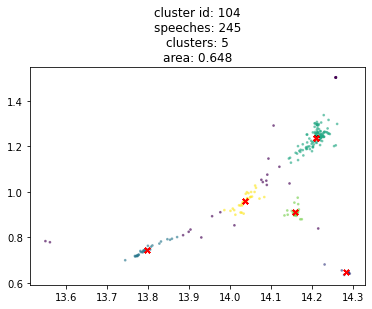

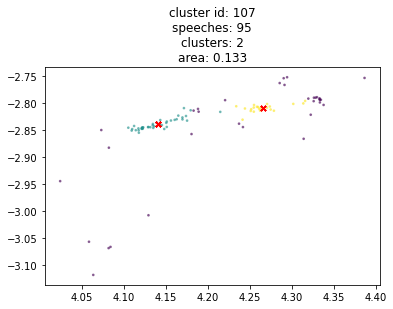

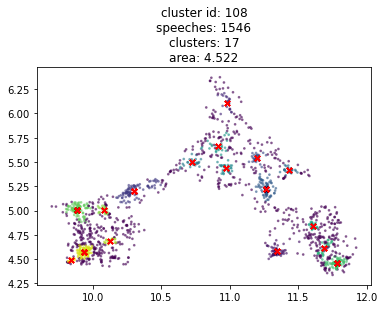

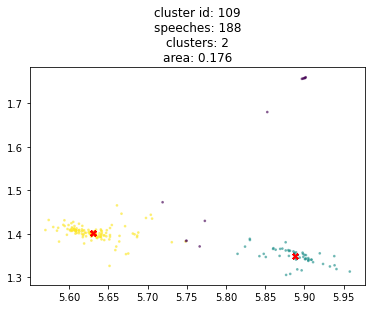

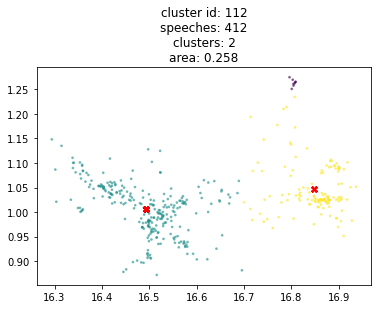

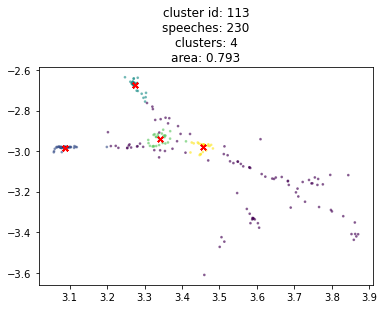

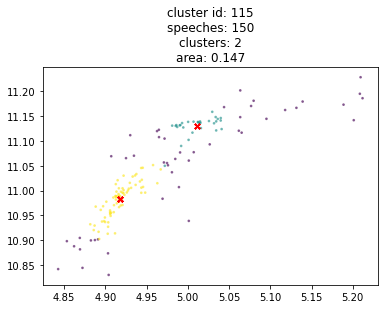

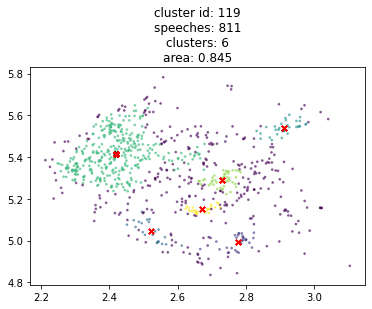

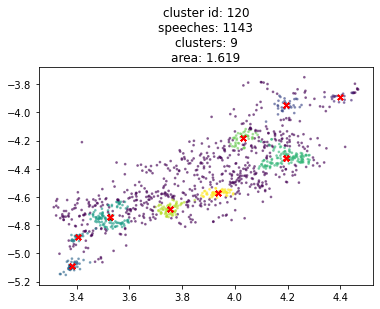

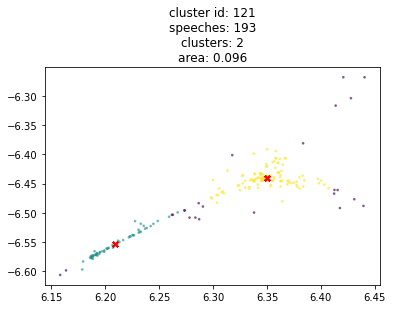

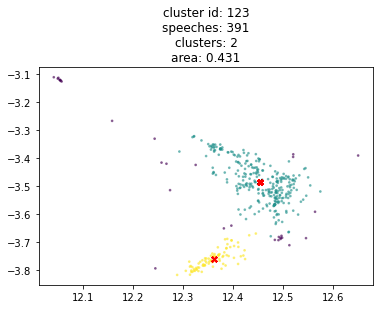

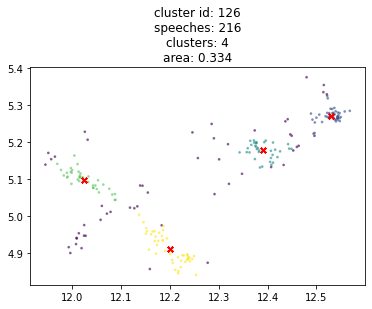

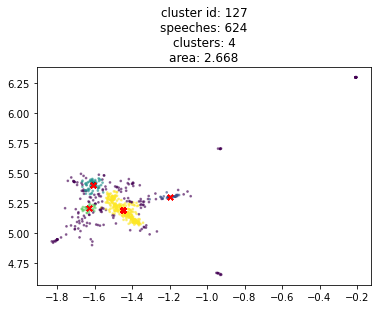

In [21]:
n_sub_clusters = np.array([len(np.unique(v[v != -1])) for v in sub_clusters.values()])

clusters_mult_sub = np.where(n_sub_clusters > 1)[0]

print(f'{len(clusters_mult_sub)} clusters with >1 cluster (excluding noise)\n')

for cluster_id in clusters_mult_sub:
    ids = np.where(cluster_labels == cluster_id)[0]
    X_cluster = X[ids]
    plt.scatter( X[ids, 0], X[ids, 1], c=sub_clusters[cluster_id],
                 s=3, alpha=0.5)
    plt.title(f'cluster id: {cluster_id}\nspeeches: {len(ids)}\nclusters: {len(np.unique(sub_clusters[cluster_id])) - 1}\narea: {str(np.around(sq_area(X_cluster), 3))}')
    
    centroids = get_centroids(X_cluster, sub_clusters[cluster_id])
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='r', s=20)
    plt.show()

to-do:

* ~~plot clusters with multiple clusters at larger scale~~
* write function to extract information from a given set of speeches (tfidf on every speech in dataframe and aggregate tfidf vectors for speeches in each subcluster)

## Analyse subclusters

In [278]:
def tfidf_to_topwords(tfidf=cluster_tfidf, id2w=id2w, topn=25): 
    tfidf_arr = tfidf.toarray()
    top_word_ids = np.argsort(tfidf_arr, axis=1)[:, ::-1][:, :topn]
    top_words = np.vectorize(id2w.get)(top_word_ids)
    top_vals = np.take_along_axis(tfidf_arr, top_word_ids, axis=1)
    return top_words, top_vals

In [264]:
def flatten(list_of_lists):
    res = []
    for l in list_of_lists:
        res += l
    return res

### tfidf all clusters

aggregate lemmas of speeches in each cluster

In [295]:
df_f['cluster'] = cluster_labels
groups = df_f.groupby('cluster')
df_clusters = groups.agg({'lemmas_ngrams': list})
df_clusters['size'] = groups.count().speech

In [296]:
df_clusters['lemmas_ngrams'] = df_clusters.lemmas_ngrams.apply(flatten)

In [297]:
df_clusters.head()

lemmas_ngrams  size
cluster                                                         
-1       [gentleman, explain, set, artificially, high, ...  2113
 0       [permission_mr_speaker, wish, statement, mid, ...  1255
 1       [british, ministers, raise, cyprus, settlement...    35
 2       [having, watch, debate, diplomacy, falklands, ...    98
 3       [order, mr_speaker, ask, place, leader, look, ...    71

In [269]:
from sklearn.feature_extraction.text import TfidfVectorizer
dummy = lambda x: x
vectorizer = TfidfVectorizer(max_df=0.8, tokenizer=dummy, lowercase=False)
all_clusters_tfidf = vectorizer.fit_transform(df_clusters.lemmas_ngrams.values)
id2w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [282]:
all_clusters_top_words, all_clusters_top_vals = tfidf_to_topwords(tfidf=all_clusters_tfidf, id2w=id2w, topn=25)

In [298]:
df_clusters['tfidf_top_words'] = pd.Series([], dtype='object')
df_clusters['tfidf_top_vals'] = pd.Series([], dtype='object')

In [299]:
df_clusters['tfidf_top_words'] = list(all_clusters_top_words)
df_clusters['tfidf_top_vals'] = list(all_clusters_top_vals)

In [300]:
df_clusters

lemmas_ngrams  size  \
cluster                                                            
-1       [gentleman, explain, set, artificially, high, ...  2113   
 0       [permission_mr_speaker, wish, statement, mid, ...  1255   
 1       [british, ministers, raise, cyprus, settlement...    35   
 2       [having, watch, debate, diplomacy, falklands, ...    98   
 3       [order, mr_speaker, ask, place, leader, look, ...    71   
...                                                    ...   ...   
 123     [grateful, opportunity, raise, new, parliament...   391   
 124     [area, long_term, deprivation, long_term, bene...   185   
 125     [afghanistan, priority, set, national, securit...   113   
 126     [hope, able, contribution, later, gentleman, a...   216   
 127     [wish, present, petition_resident, ayr, carric...   624   

                                           tfidf_top_words  \
cluster                                                      
-1       [hezbollah, euratom, corporation_tax, nhs, abu...   
 0       [nhs, gps, gp, e, clinical, ccg, junior_doctor...   
 1       [turkey, turkish, cyprus, erdoğan, famagusta, ...   
 2       [iraq, chilcot, saddam, genocide, hussein, ira...   
 3       [bills, second_reading, expenditure, constitue...   
...                                                    ...   
 123     [flood, flooding, environment_agency, flood_de...   
 124     [youth_unemployment, unemployment, apprentices...   
 125     [afghan, afghanistan, isaf, helmand, taliban, ...   
 126     [insurance, whiplash, internet, pornography, i...   
 127     [petition, petition_resident, petitioners, pet...   

                                            tfidf_top_vals  
cluster                                                     
-1       [0.2106956538411482, 0.15306519261784773, 0.12...  
 0       [0.8444155481110923, 0.14350966746412866, 0.13...  
 1       [0.7811218756242506, 0.40833034445780847, 0.28...  
 2       [0.5304540903251336, 0.4278127653340377, 0.344...  
 3       [0.5901303840644282, 0.44332517352939466, 0.17...  
...                                                    ...  
 123     [0.6273351661896492, 0.36932887552254084, 0.29...  
 124     [0.6306295783923085, 0.4475253992839621, 0.380...  
 125     [0.6559688552997797, 0.5662049356649859, 0.183...  
 126     [0.5728327286761472, 0.23895173740049336, 0.23...  
 127     [0.4277902507680116, 0.42670088033643294, 0.40...  

[129 rows x 4 columns]

### inspect mean tfidf of cluster vs its subclusters

In [201]:
import matplotlib.cm

In [339]:
def get_subclusters_df(cluster_id, df=df_f, drop_noise=True, sub_clusters=sub_clusters, cluster_labels=cluster_labels):
    ids = np.where(cluster_labels == cluster_id)[0]
    
    df_cluster = df.iloc[ids]
    df_cluster['subcluster'] = sub_clusters[cluster_id]
    
    groups = df_cluster.groupby('subcluster')
    df_cluster = groups.agg({'lemmas_ngrams': list})
    
    df_cluster['lemmas_ngrams'] = df_cluster.lemmas_ngrams.apply(flatten)
    
    if drop_noise:
        return df_cluster.drop(-1)
    else:
        return df_cluster
    
def get_tfidf(texts, max_df=None):
    dummy = lambda x: x
    vectorizer = TfidfVectorizer(max_df=1.0, tokenizer=dummy, lowercase=False)
    tfidf = vectorizer.fit_transform(texts)
    id2w = {v:k for k,v in vectorizer.vocabulary_.items()}
    return tfidf, id2w

def get_subcluster_topwords(cluster_id, df=df_f, X=X, drop_noise=True, topn=25, df_clusters=df_clusters, sub_clusters=sub_clusters, cluster_labels=cluster_labels):
    
    # dataframe for cluster cluster_id, each row a different subcluster
    cluster_df = get_subclusters_df(cluster_id=cluster_id, df=df, drop_noise=drop_noise, sub_clusters=sub_clusters, cluster_labels=cluster_labels)
    
    # fit tfidf to texts in the cluster, grouped by cluster
    # if drop_noise is True, only look at speeches assigned to a subcluster
    subcluster_tfidf, id2w = get_tfidf(cluster_df.lemmas_ngrams.values)
    
    # get the topwords and corresponding tfidf values for each of the subclusters
    top_words, top_vals = tfidf_to_topwords(tfidf=subcluster_tfidf, id2w=id2w, topn=topn)
    
    cluster_df['tfidf_top_words'] = pd.Series([], dtype='object')
    cluster_df['tfidf_top_vals'] = pd.Series([], dtype='object')
    
    cluster_df['tfidf_top_words'] = list(top_words)
    cluster_df['tfidf_top_vals'] = list(top_vals)
    
    # for comparison, get tfidf topwords&vals for the whole cluster
    cluster_top_words, cluster_top_vals = df_clusters.loc[cluster_id][['tfidf_top_words', 'tfidf_top_vals']].values.T
    
    print('cluster top tfidf words (wrt all speeches)')
    print(cluster_top_words)
    
    plot_subclusters(cluster_id, X)
    
    print('subcluster top tfidf words (wrt cluster)')
    for i in cluster_df.index:
        print(f'subcluster: {i}')
        print(cluster_df.loc[i].tfidf_top_words)
        print('\n')
        
def plot_subclusters(cluster_id, X, sub_clusters=sub_clusters, cluster_labels=cluster_labels):
    # get ids of points in cluster cluster_id
    ids = np.where(cluster_labels == cluster_id)[0]
    
    # explicitly get coordinates of cluster points
    X_cluster = X[ids]
    
    cmap = plt.get_cmap('viridis', len( np.unique(sub_clusters[cluster_id]) )-1)
    cmap.set_under('lightgrey')
    
    # plot these points coloured by sub_cluster
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter( X[ids, 0], X[ids, 1], c=cmap(sub_clusters[cluster_id]),
                s=3, alpha=0.5, vmin=0)
    ax.set_title(f'cluster id: {cluster_id}\nspeeches: {len(ids)}\nclusters: {len(np.unique(sub_clusters[cluster_id])) - 1}\narea: {str(np.around(sq_area(X_cluster), 3))}')
    
    # for each subcluster (except for 'noise': -1), find the centroid and plot it
    centroids = get_centroids(X_cluster, sub_clusters[cluster_id])
#     ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='r', s=200)
    
    # annotate each subcluster with its id
    for i, (x,y) in enumerate(centroids):
        ax.text(x, y, i, ha='center', va='center', size=10, alpha=1, c='k',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=cmap(i), lw=2, alpha=0.75))
    plt.show()

cluster top tfidf words (wrt all speeches)
['apprenticeship' 'apprentice' 'employer' 'college' 'vocational'
 'qualification' 'fe' 'utc' 'engineering' 'math' 'learning' 'skills'
 'academic' 'youth_unemployment' 'learner' 'procurement' 'english_math'
 'pupil' 'gcse' 'adult' 'careers' 'provider' 'girl' 'science' 'stem']


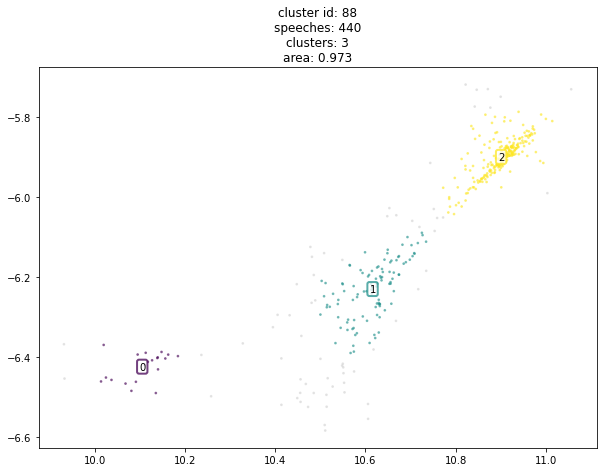

subcluster top tfidf words (wrt cluster)
subcluster: 0
['college' 'education' 'student' 'funding' 'course' 'provision'
 'st_austell' 'skill' 'adult' 'level' 'cut' 'young' 'cornwall' 'high'
 'number' 'fe' 'study' 'school' 'enfield' 'offer' 'review' 'sixth_form'
 'impact' 'sector' 'sixth_form_college']


subcluster: 1
['education' 'young' 'school' 'career' 'skill' 'apprenticeship'
 'technical' 'high' 'advice' 'employer' 'college' 'business' 'ensure'
 'student' 'opportunity' 'level' 'new' 'provide' 'quality' 'qualification'
 'company' 'vocational' 'university' 'important' 'service']


subcluster: 2
['apprenticeship' 'young' 'apprentice' 'employer' 'skill' 'training'
 'number' 'business' 'education' 'opportunity' 'job' 'high' 'new' 'level'
 'increase' 'constituency' 'ensure' 'quality' 'gentleman' 'school'
 'important' 'company' 'start' 'college' 'go']




In [347]:
get_subcluster_topwords(88)

# *subcluster tfidf still looks similar - think of way to tackle this*

revert to original tactic of tfidfing all speeches

subtract cluster average from each subcluster average

then take tfidf ids with greatest magnitude - these are the words that appear much more or much less in the subcluster than the overall cluster

if these are nonsense could point towards subclusters not representing any subtopics/frames

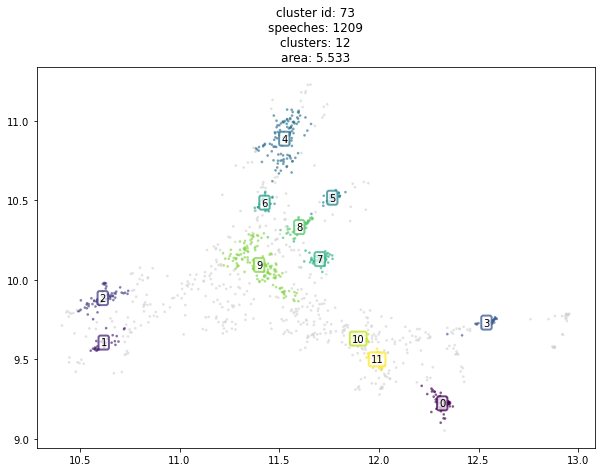

In [340]:
plot_subclusters(73, X)

# cluster speeches EDA

In [239]:
df_f['cluster'] = cluster_labels

In [240]:
with open(f'filtered_dt.pkl', 'rb') as f:
    dt = pickle.load(f)

N = 90
with open(f'topic-models/coarse/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [241]:
dt.shape

(43771, 90)

In [242]:
df_f['topic_dist'] = list(dt)

In [243]:
df_f.sample(5)

speech  \
date       heading                                            display_as                                                           
2013-01-08 ATTORNEY-GENERAL South London Healthcare NHS Trust Joan Ruddock     (Urgent Question): To ask the Secretary of Sta...   
2011-03-21 United Nations Security Council Resolution 1973    James Arbuthnot  It is a pleasure to follow the hon Member for ...   
2014-12-16 JUSTICE Whiplash Claims                            Shailesh Vara    The Government are taking forward a whiplash r...   
2012-06-21 Business of the House Interest Rate Swap Products  Damian Collins   I, too, congratulate my hon Friend on securing...   
2017-04-27 EXITING THE EUROPEAN UNION Employment and Worke... David Davis      I shall start by saying that I am going to dis...   

                                                                                                                   lemmas_ngrams  \
date       heading                                            display_as                                                           
2013-01-08 ATTORNEY-GENERAL South London Healthcare NHS Trust Joan Ruddock     [urgent, question, ask, health, statement, tru...   
2011-03-21 United Nations Security Council Resolution 1973    James Arbuthnot  [pleasure_follow, merthyr, tydfil, rhymney, mr...   
2014-12-16 JUSTICE Whiplash Claims                            Shailesh Vara    [forward, whiplash, reform, programme, deter, ...   
2012-06-21 Business of the House Interest Rate Swap Products  Damian Collins   [congratulate, secure, debate, share, concern,...   
2017-04-27 EXITING THE EUROPEAN UNION Employment and Worke... David Davis      [shall, start, go, disappoint, huddersfield_mr...   

                                                                                                                           sents  \
date       heading                                            display_as                                                           
2013-01-08 ATTORNEY-GENERAL South London Healthcare NHS Trust Joan Ruddock     [(Urgent Question): To ask the Secretary of St...   
2011-03-21 United Nations Security Council Resolution 1973    James Arbuthnot  [It is a pleasure to follow the hon Member for...   
2014-12-16 JUSTICE Whiplash Claims                            Shailesh Vara    [The Government are taking forward a whiplash ...   
2012-06-21 Business of the House Interest Rate Swap Products  Damian Collins   [I, too, congratulate my hon Friend on securin...   
2017-04-27 EXITING THE EUROPEAN UNION Employment and Worke... David Davis      [I shall start by saying that I am going to di...   

                                                                               cluster  \
date       heading                                            display_as                 
2013-01-08 ATTORNEY-GENERAL South London Healthcare NHS Trust Joan Ruddock           0   
2011-03-21 United Nations Security Council Resolution 1973    James Arbuthnot      100   
2014-12-16 JUSTICE Whiplash Claims                            Shailesh Vara        126   
2012-06-21 Business of the House Interest Rate Swap Products  Damian Collins        43   
2017-04-27 EXITING THE EUROPEAN UNION Employment and Worke... David Davis           12   

                                                                                                                      topic_dist  
date       heading                                            display_as                                                          
2013-01-08 ATTORNEY-GENERAL South London Healthcare NHS Trust Joan Ruddock     [0.0014914243102162, 0.0082028337061894, 0.001...  
2011-03-21 United Nations Security Council Resolution 1973    James Arbuthnot  [0.0007168458781362007, 0.0007168458781362007,...  
2014-12-16 JUSTICE Whiplash Claims                            Shailesh Vara    [0.0016460905349794, 0.0016460905349794, 0.046...  
2012-06-21 Business of the House Interest Rate Swap Products 

In [244]:
groups = df_f.groupby('cluster')

In [257]:
df_clusters = groups.agg({'lemmas_ngrams': list})

In [258]:
df_clusters['topic_dist'] = groups['topic_dist'].apply(np.mean)

In [259]:
df_clusters['size'] = groups.count().speech

In [260]:
def flatten(list_of_lists):
    res = []
    for l in list_of_lists:
        res += l
    return res

# def flatten_lemmas(el):
#     return flatten(el.values.ravel()[0])

In [261]:
df_clusters['lemmas_ngrams'] = df_clusters.lemmas_ngrams.apply(flatten)

In [262]:
df_clusters

lemmas_ngrams  \
cluster                                                      
-1       [gentleman, explain, set, artificially, high, ...   
 0       [permission_mr_speaker, wish, statement, mid, ...   
 1       [british, ministers, raise, cyprus, settlement...   
 2       [having, watch, debate, diplomacy, falklands, ...   
 3       [order, mr_speaker, ask, place, leader, look, ...   
...                                                    ...   
 123     [grateful, opportunity, raise, new, parliament...   
 124     [area, long_term, deprivation, long_term, bene...   
 125     [afghanistan, priority, set, national, securit...   
 126     [hope, able, contribution, later, gentleman, a...   
 127     [wish, present, petition_resident, ayr, carric...   

                                                topic_dist  size  
cluster                                                           
-1       [0.015475817399930113, 0.008681799485169336, 0...  2113  
 0       [0.0036386308605191892, 0.003513229173595326, ...  1255  
 1       [0.00421618045174152, 0.008570192871724598, 0....    35  
 2       [0.0037740910280499754, 0.005462603925415624, ...    98  
 3       [0.0035255847845497377, 0.005490582281433741, ...    71  
...                                                    ...   ...  
 123     [0.0024318104154213427, 0.0032181360061401027,...   391  
 124     [0.004420460846263253, 0.0030051432217898326, ...   185  
 125     [0.0035936989662549326, 0.003895948218108849, ...   113  
 126     [0.004843380439754552, 0.007146316051960121, 0...   216  
 127     [0.00943645172417646, 0.004590009430024063, 0....   624  

[129 rows x 3 columns]

## LDA topic distribution in clusters

In [44]:
from scipy.stats import entropy
df_cluster['entropy'] = entropy(np.vstack(df_cluster.topic_dist.values), base=2, axis=1)

In [45]:
df_cluster['I_eff'] = 2 ** df_cluster.entropy

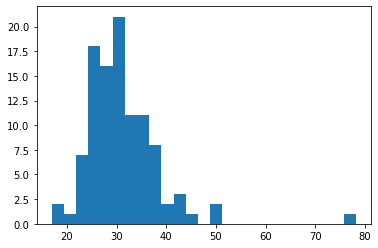

In [46]:
plt.hist(df_cluster.I_eff, bins=25)
plt.show()

(0.516760983154645, 1.9566833517341594e-08)


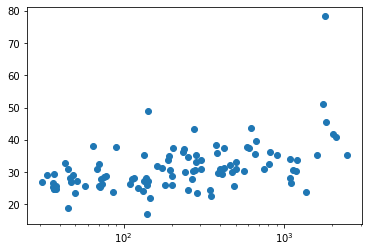

In [47]:
x = df_cluster['size']
y = df_cluster['I_eff']
plt.scatter(x, y)
plt.xscale('log')

from scipy.stats import pearsonr
print(pearsonr(x,y))

In [48]:
df_centroids = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})[[0,1]]

In [49]:
df_centroids.head(5)

0         1
             mean      mean
cluster                    
-1       1.149169  6.822097
 0      -6.447680  5.987081
 1      -3.057210  9.908222
 2      -3.964264  1.009647
 3       1.951609  8.386499

### tfidf

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
dummy = lambda x: x
vectorizer = TfidfVectorizer(max_df=0.8, tokenizer=dummy, lowercase=False)
cluster_tfidf = vectorizer.fit_transform(df_cluster.lemmas_ngrams.values)

In [51]:
id_to_w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [52]:
cluster_tfidf_word_ids = np.argsort(cluster_tfidf.toarray(), axis=1)[:, ::-1][:, :10]

In [53]:
cluster_tfidf_word_ids[0]

array([32294, 28568, 16654, 48142, 58112, 47446, 68161, 45036, 36586,
       72674])

In [54]:
top_vocab_words = np.vectorize(id_to_w.get)(cluster_tfidf_word_ids)

In [55]:
df_cluster['tfidf_words'] = [" ".join(x) for x in top_vocab_words]

## summarise clusters

In [56]:
def plot_cluster_topic_dist(cluster_id, df_cluster=df_cluster):
    plt.figure(figsize=(20,5))
    
    dist = df_cluster.loc[cluster_id].topic_dist
    N = len(dist)
    
    mu = np.mean(dist)
    std = np.std(dist)
    
    significant_topic_ids = np.where((dist - mu)/std > 1)[0]
    
    colors = np.repeat('k', N)
    colors[significant_topic_ids] = 'r'
    
    plt.bar(np.arange(N), dist,
           color=colors)
    plt.xticks(np.arange(0,N,5))
    
    plt.title(f'cluster {cluster_id} topic distribution')
    plt.show()
    
    order = np.argsort(dist[significant_topic_ids])[::-1]
    return zip(significant_topic_ids[order], dist[significant_topic_ids][order])

def summarise_cluster(cluster_id, df_cluster=df_cluster):
    significant_topic_ids = plot_cluster_topic_dist(cluster_id, df_cluster)
    for topic_id, p in significant_topic_ids:
        print(f'{topic_id}  {np.around(p, 3)}\n{lda.print_topic(topic_id)}\n')
        
    print(f'top tfidf words: {df_cluster.loc[cluster_id, "tfidf_words"]}\n')
    
    print(f"size: {df_cluster.loc[cluster_id,'size']}")
    print(f'centroid: {df_centroids.loc[cluster_id].values}')
    print('\n')

### most coherence clusters by LDA topic distribution

In [57]:
most_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').head(10).index
df_cluster.loc[most_coherent_cluster_ids]

lemmas_ngrams  \
cluster                                                      
42       [wish, raise, briefly, animal_welfare, dare, s...   
97       [indicate_dissent, grateful, gentleman, mentio...   
94       [warmly, congratulate, secure, adjournment_deb...   
9        [welcome, ministerial_team, position, role, as...   
82       [yemen, high, priority, coalition, subject, de...   
26       [congratulate, secure, important, debate, repr...   
33       [order, interruption, let, chief_secretary, re...   
66       [beg, leave, bring, bill, exempt, public, priv...   
79       [congratulate, appointment, mr_deputy_speaker,...   
62       [grateful, foreign_secretary, statement, advan...   

                                                topic_dist  size   entropy  \
cluster                                                                      
42       [0.002166230899266715, 0.0021101533986567548, ...   140  4.082147   
97       [0.0022638006221485166, 0.0030223065588064198,...    45  4.226823   
94       [0.004976231983011994, 0.0064379519973229585, ...   146  4.447357   
9        [0.004644944160153606, 0.003829418350446359, 0...   351  4.490243   
82       [0.004259286886584657, 0.003854249192962981, 0...   285  4.546908   
26       [0.003343653098552418, 0.006052110392793919, 0...    50  4.554290   
33       [0.005015459847695998, 0.005305724542247085, 0...  1371  4.563964   
66       [0.00203025066432153, 0.00405430360602116, 0.0...    86  4.578620   
79       [0.0033313999163716137, 0.005045886290408773, ...   131  4.597830   
62       [0.005384199841610267, 0.004514297631110762, 0...   347  4.600652   

             I_eff                                        tfidf_words  
cluster                                                                
42       16.937476  badger cull cattle tb bovine_tb vaccine vaccin...  
97       18.724080  certification certify resume england_wales com...  
94       21.816639  holocaust jewish auschwitz holocaust_memorial ...  
9        22.474911  fisherman fishery fishing fish quota fishing_i...  
82       23.375218  yemen saudi_arabia saudi houthis humanitarian ...  
26       23.495130  mandela nelson_mandela apartheid south_africa ...  
33       23.653204  accommodate calm courtesy brevity shout catch_...  
66       23.894718  tobacco smoking cigarette smoke smoker packagi...  
79       24.215010  iran iranian nuclear nuclear_weapon iranians t...  
62       24.262435  israel palestinian gaza israeli palestinians h...

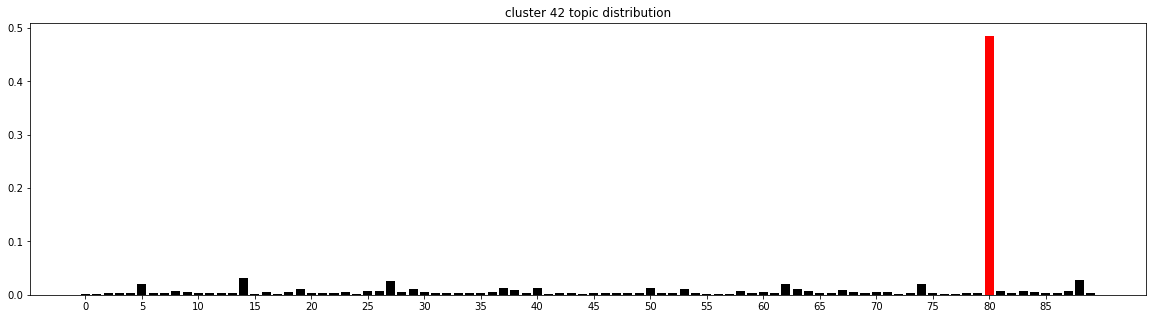

80  0.485
0.027*"dog" + 0.023*"animal" + 0.012*"disease" + 0.010*"ban" + 0.010*"control" + 0.009*"badger" + 0.008*"cattle" + 0.008*"animal_welfare" + 0.008*"cull" + 0.007*"tb"

top tfidf words: badger cull cattle tb bovine_tb vaccine vaccination disease farmer badger_cull

size: 140
centroid: [-4.7806845 13.930322 ]




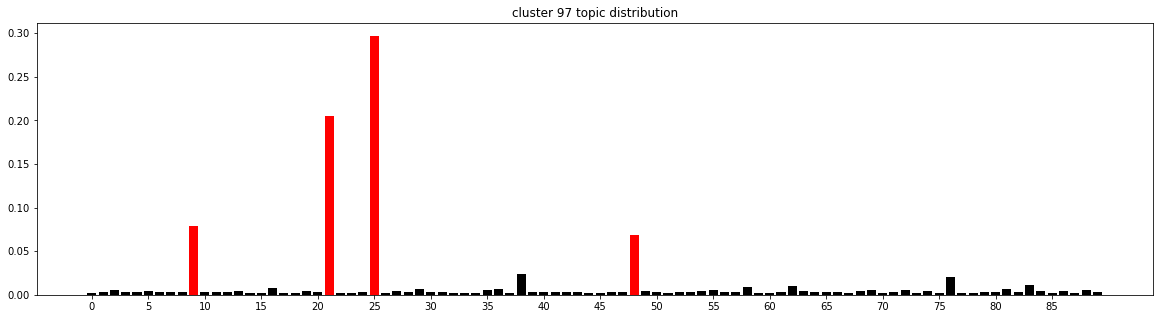

25  0.297
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

21  0.205
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

9  0.079
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

48  0.068
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

top tfidf words: certification certify resume england_wales competenceclause exclusively doorkeepers certificate m forthwith

size: 45
centroid: [ 0.11013772 16.724287  ]




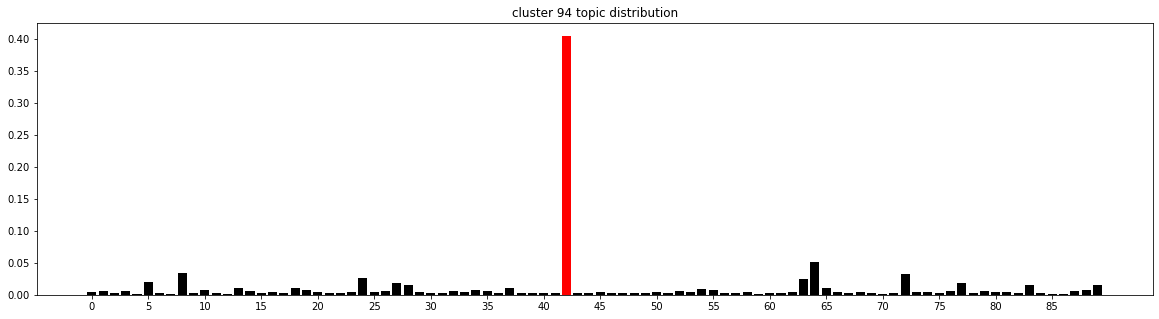

42  0.405
0.037*"war" + 0.016*"world" + 0.016*"day" + 0.011*"man" + 0.010*"remember" + 0.008*"event" + 0.008*"kill" + 0.008*"british" + 0.008*"history" + 0.007*"today"

top tfidf words: holocaust jewish auschwitz holocaust_memorial anti_semitism jews antisemitism genocide survivor birkenau

size: 146
centroid: [-0.5324726  -0.88853884]




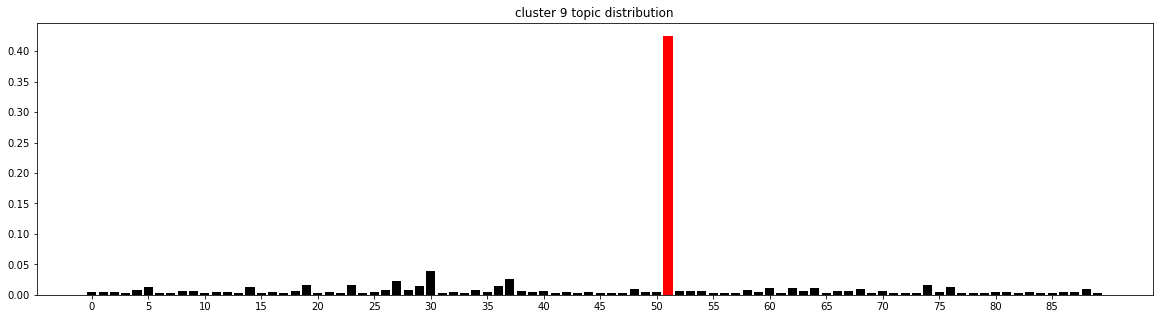

51  0.425
0.019*"port" + 0.016*"fishing" + 0.016*"fish" + 0.015*"sea" + 0.011*"fishery" + 0.011*"fisherman" + 0.010*"uk" + 0.009*"water" + 0.009*"catch" + 0.009*"marine"

top tfidf words: fisherman fishery fishing fish quota fishing_industry discard common_fishery_policy cfp vessel

size: 351
centroid: [9.832447  5.7294903]




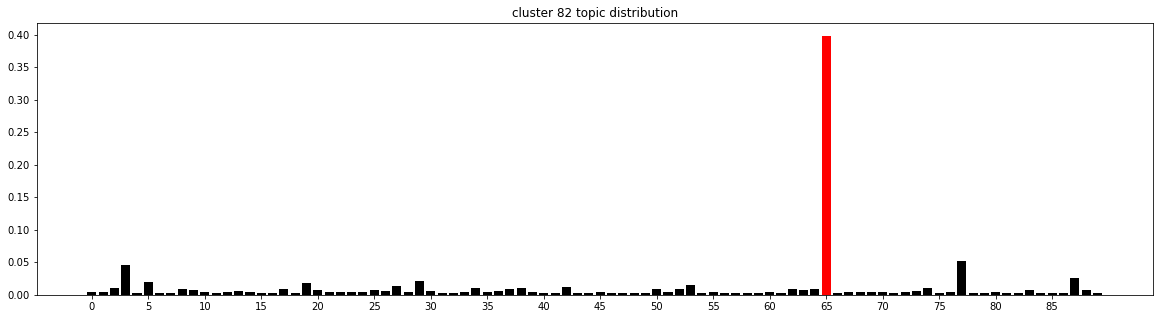

65  0.398
0.019*"refugee" + 0.014*"humanitarian" + 0.014*"conflict" + 0.014*"international" + 0.013*"yemen" + 0.012*"uk" + 0.012*"syria" + 0.010*"situation" + 0.009*"million" + 0.009*"provide"

top tfidf words: yemen saudi_arabia saudi houthis humanitarian un yemeni saudis houthi ceasefire

size: 285
centroid: [ 4.551248 16.238636]




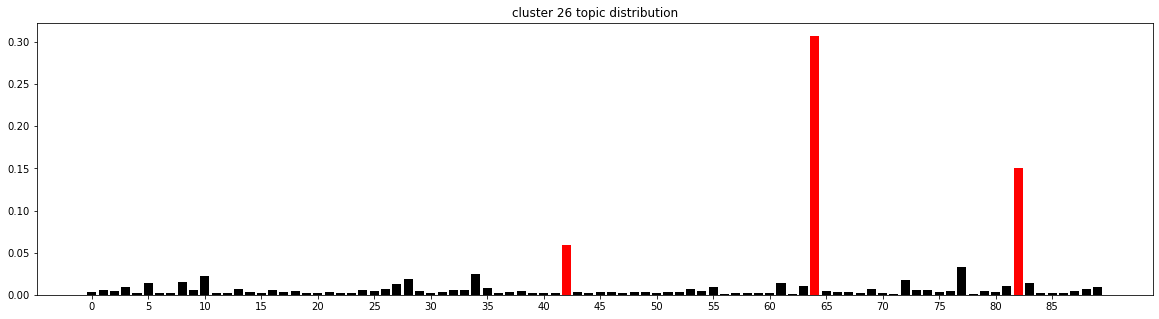

64  0.307
0.021*"great" + 0.013*"life" + 0.012*"today" + 0.011*"world" + 0.010*"day" + 0.010*"speak" + 0.009*"stand" + 0.008*"nation" + 0.008*"proud" + 0.008*"politic"

82  0.15
0.041*"petition" + 0.020*"recall" + 0.020*"urge" + 0.019*"constituent" + 0.017*"sign" + 0.017*"state" + 0.017*"commons" + 0.016*"mr" + 0.013*"john" + 0.011*"constituency"

42  0.059
0.037*"war" + 0.016*"world" + 0.016*"day" + 0.011*"man" + 0.010*"remember" + 0.008*"event" + 0.008*"kill" + 0.008*"british" + 0.008*"history" + 0.007*"today"

top tfidf words: mandela nelson_mandela apartheid south_africa anc african reconciliation forgiveness africans robben

size: 50
centroid: [11.210242  -0.5135203]




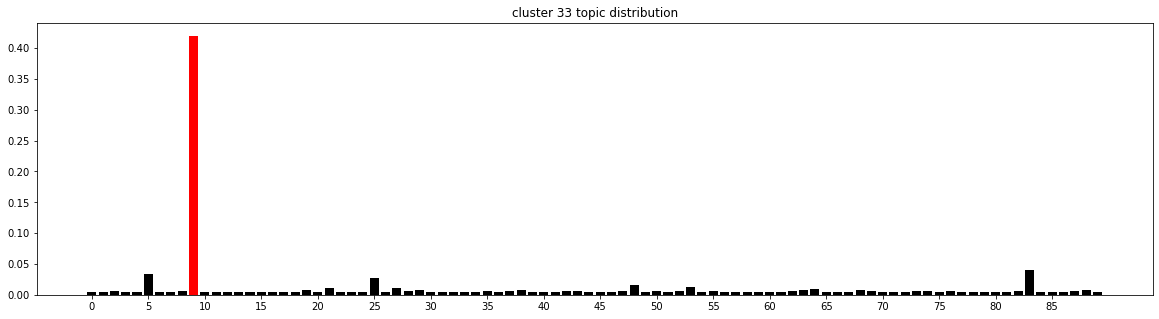

9  0.42
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

top tfidf words: accommodate calm courtesy brevity shout catch_eye sedentary_position noise pm interrupt

size: 1371
centroid: [ 0.813114 17.727764]




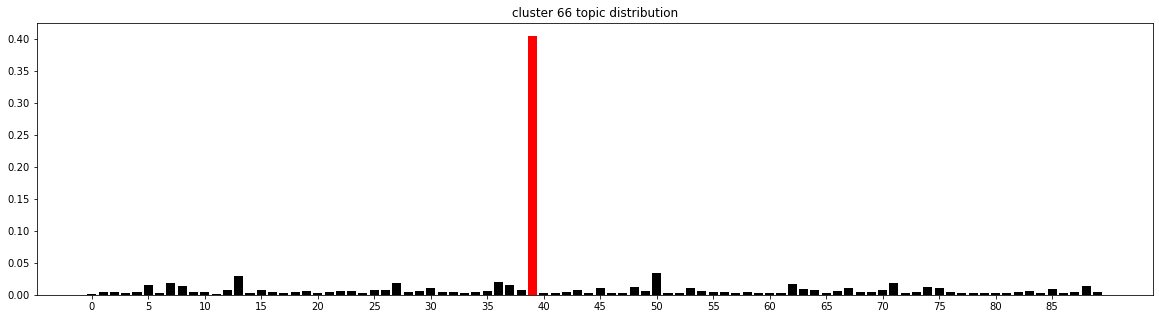

39  0.405
0.028*"drug" + 0.018*"alcohol" + 0.016*"waste" + 0.012*"health" + 0.011*"public" + 0.011*"ban" + 0.011*"evidence" + 0.010*"product" + 0.010*"smoking" + 0.010*"tobacco"

top tfidf words: tobacco smoking cigarette smoke smoker packaging e standardised illicit quit

size: 86
centroid: [-3.0164113  2.2350872]




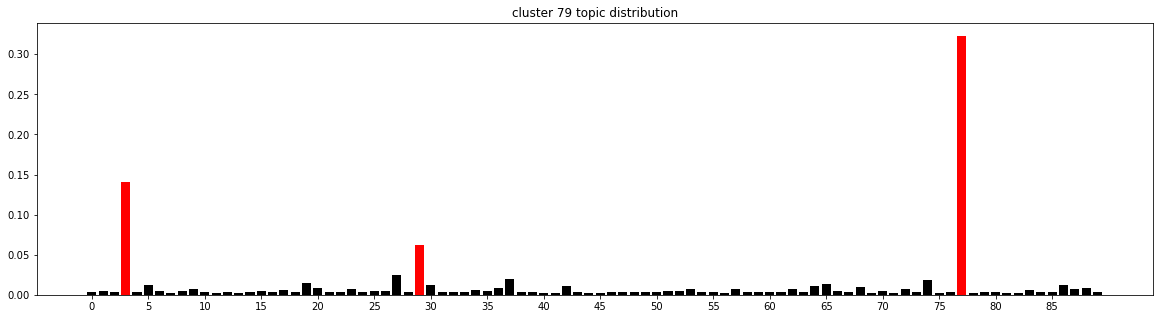

77  0.323
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

3  0.141
0.015*"russia" + 0.014*"action" + 0.013*"syria" + 0.013*"iraq" + 0.012*"security" + 0.012*"military" + 0.009*"force" + 0.009*"russian" + 0.009*"nato" + 0.008*"world"

29  0.062
0.026*"process" + 0.023*"clear" + 0.018*"agreement" + 0.015*"decision" + 0.014*"set" + 0.014*"gentleman" + 0.012*"deal" + 0.011*"place" + 0.010*"hope" + 0.010*"discussion"

top tfidf words: iran iranian nuclear nuclear_weapon iranians tehran iaea jcpoa israel foreign_secretary

size: 131
centroid: [-8.082061   4.7845364]




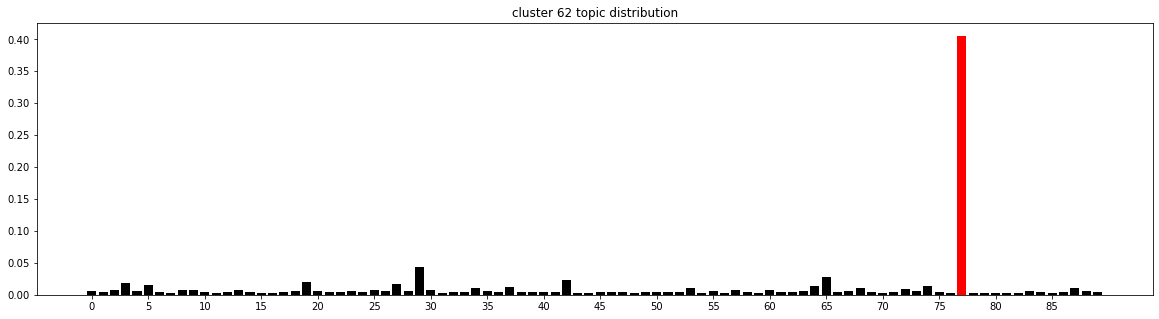

77  0.405
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

top tfidf words: israel palestinian gaza israeli palestinians hamas peace palestine israelis jerusalem

size: 347
centroid: [-8.341888  5.616629]




In [58]:
for cluster_id in most_coherent_cluster_ids:
    summarise_cluster(cluster_id)

### least coherent clusters by LDA topic distribution

In [59]:
least_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').tail(10).index
df_cluster.loc[least_coherent_cluster_ids]

lemmas_ngrams  \
cluster                                                      
 22      [congratulate, enfield, north, nick, de, bois,...   
 25      [gentleman, past, probably, past, product, sel...   
 30      [mr_speaker, extremely, grateful, shadow_chanc...   
 90      [congratulate, bosworth, david, tredinnick, se...   
 89      [intend, replace, rda, local_enterprise_partne...   
 17      [wish, present, petition_resident, ayr, carric...   
 3       [gentleman, explain, set, artificially, high, ...   
 43      [welcome, benches, delight, distinguished, aut...   
 60      [congratulate, north_durham_mr_jones, secure, ...   
-1       [thank, deputy_speaker, opportunity, maiden_sp...   

                                                topic_dist  size   entropy  \
cluster                                                                      
 22      [0.0035217201462920266, 0.004377841908799308, ...   377  5.256986   
 25      [0.004053764901176655, 0.0033777534844312883, ...   667  5.304930   
 30      [0.003143015929028124, 0.0037376664556521473, ...  2096  5.351954   
 90      [0.00364195451450561, 0.0033703087779803718, 0...  2021  5.387757   
 89      [0.0042683477244087244, 0.002960260883339046, ...   274  5.435543   
 17      [0.009458969248821166, 0.004610697122681743, 0...   620  5.452449   
 3       [0.004407708826533734, 0.007175805230851291, 0...  1823  5.509637   
 43      [0.005544187097704923, 0.006212015580103851, 0...   141  5.615965   
 60      [0.009379979115924694, 0.03664505885398492, 0....  1748  5.674619   
-1       [0.006739903638261668, 0.0047402976121064784, ...  1791  6.289902   

             I_eff                                        tfidf_words  
cluster                                                                
 22      38.239351  devolution silk_commission income_tax referend...  
 25      39.531481  steel steel_industry manufacturing export tata...  
 30      40.841221  deficit obr debt tax_avoidance forecast vat hm...  
 90      41.867436  nhs cancer clinical drug gps gp clinician e cc...  
 89      43.277426  devolution rural combine_authority rural_area ...  
 17      43.787543  petition petition_resident petitioners declare...  
 3       45.558148  constitutional ipsa bills standards fix_term d...  
 43      49.042664  adjournment_debate bills tuesday european_unio...  
 60      51.077623  home_secretary terrorism terrorist intelligenc...  
-1       78.243650  hezbollah gibraltar croatia nhs referendum nat...

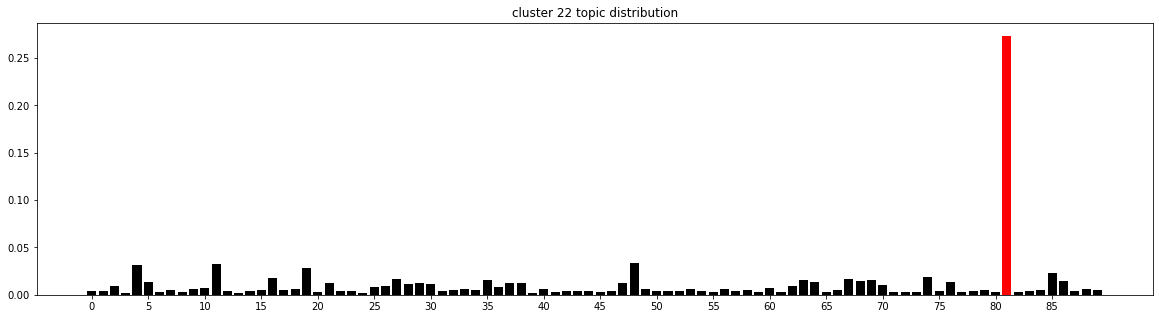

81  0.273
0.123*"wales" + 0.060*"welsh" + 0.020*"power" + 0.020*"assembly" + 0.013*"devolve" + 0.012*"cardiff" + 0.012*"uk" + 0.011*"devolution" + 0.010*"england" + 0.009*"welsh_assembly"

top tfidf words: devolution silk_commission income_tax referendum welsh_assembly borrowing plaid_cymru st_david cardiff taxis

size: 377
centroid: [-0.01327707  9.633627  ]




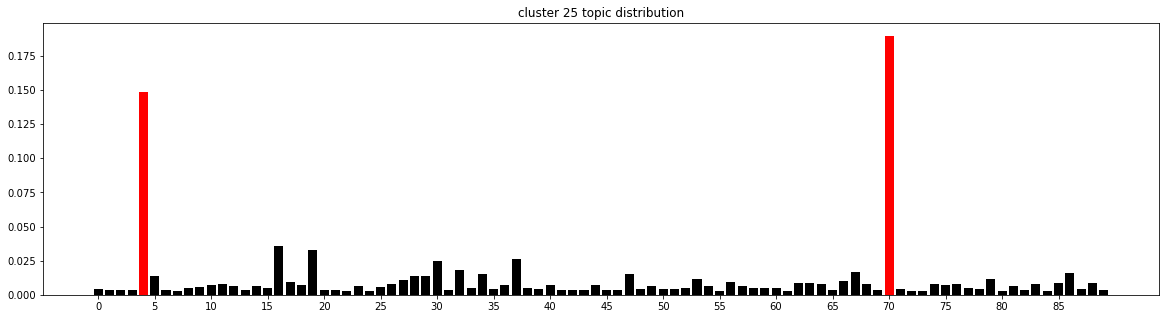

70  0.19
0.067*"industry" + 0.027*"job" + 0.026*"uk" + 0.022*"company" + 0.017*"manufacturing" + 0.017*"steel" + 0.015*"sector" + 0.013*"british" + 0.011*"future" + 0.010*"constituency"

4  0.148
0.109*"business" + 0.032*"investment" + 0.031*"economy" + 0.024*"small" + 0.022*"growth" + 0.016*"sector" + 0.016*"job" + 0.015*"uk" + 0.014*"create" + 0.013*"economic"

top tfidf words: steel steel_industry manufacturing export tata industrial_strategy automotive plant aerospace supply_chain

size: 667
centroid: [7.196556  7.3505483]




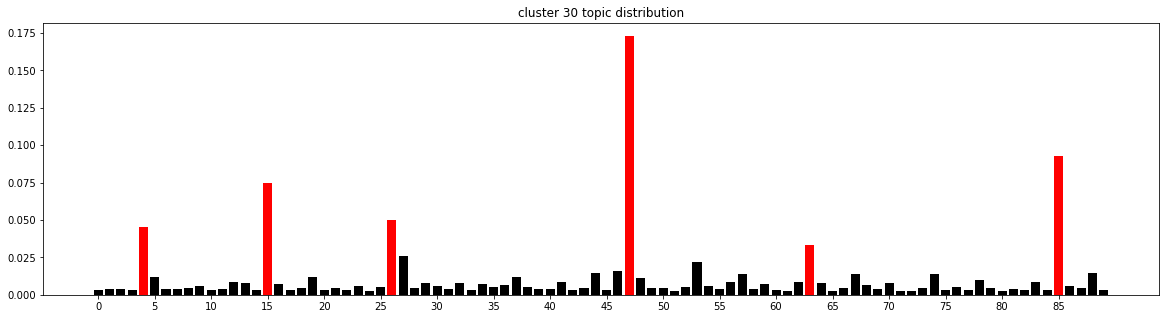

47  0.173
0.032*"economy" + 0.028*"budget" + 0.026*"economic" + 0.026*"chancellor" + 0.024*"growth" + 0.016*"deficit" + 0.016*"billion" + 0.016*"plan" + 0.013*"debt" + 0.013*"public"

85  0.093
0.071*"tax" + 0.051*"rate" + 0.028*"increase" + 0.023*"pay" + 0.017*"measure" + 0.017*"budget" + 0.015*"vat" + 0.014*"benefit" + 0.014*"high" + 0.014*"change"

15  0.075
0.053*"tax" + 0.030*"company" + 0.023*"hmrc" + 0.019*"pay" + 0.016*"uk" + 0.011*"tax_avoidance" + 0.010*"rule" + 0.009*"profit" + 0.009*"billion" + 0.008*"money"

26  0.05
0.065*"cut" + 0.014*"face" + 0.012*"lose" + 0.012*"poor" + 0.012*"fail" + 0.011*"bad" + 0.011*"budget" + 0.011*"impact" + 0.010*"real" + 0.009*"million"

4  0.045
0.109*"business" + 0.032*"investment" + 0.031*"economy" + 0.024*"small" + 0.022*"growth" + 0.016*"sector" + 0.016*"job" + 0.015*"uk" + 0.014*"create" + 0.013*"economic"

63  0.033
0.096*"labour" + 0.066*"party" + 0.033*"gentleman" + 0.033*"opposition" + 0.021*"conservative" + 0.018*"policy" + 0.013*"

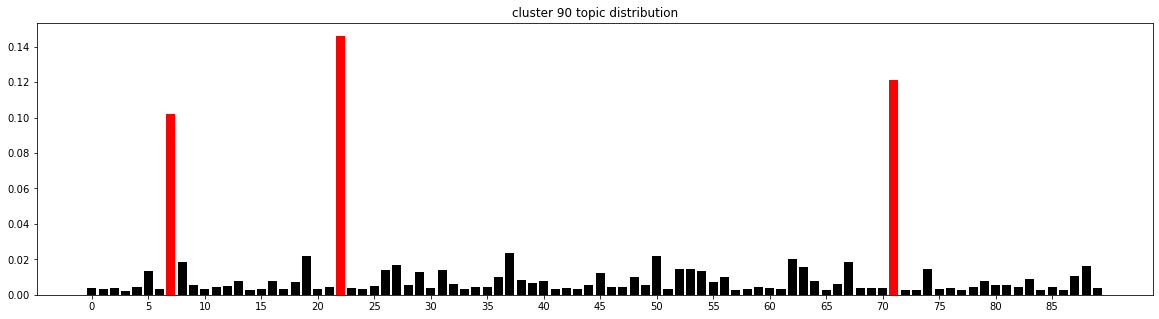

22  0.146
0.064*"hospital" + 0.034*"nhs" + 0.031*"trust" + 0.025*"patient" + 0.024*"service" + 0.023*"care" + 0.019*"staff" + 0.014*"health" + 0.012*"nurse" + 0.010*"doctor"

71  0.121
0.037*"cancer" + 0.025*"treatment" + 0.022*"patient" + 0.020*"drug" + 0.018*"research" + 0.017*"medical" + 0.012*"medicine" + 0.011*"life" + 0.008*"disease" + 0.008*"access"

7  0.102
0.094*"nhs" + 0.078*"health" + 0.060*"service" + 0.031*"patient" + 0.026*"care" + 0.016*"england" + 0.013*"public" + 0.013*"local" + 0.011*"national" + 0.010*"gps"

top tfidf words: nhs cancer clinical drug gps gp clinician e ccg nurse

size: 2021
centroid: [-3.1825125  4.726756 ]




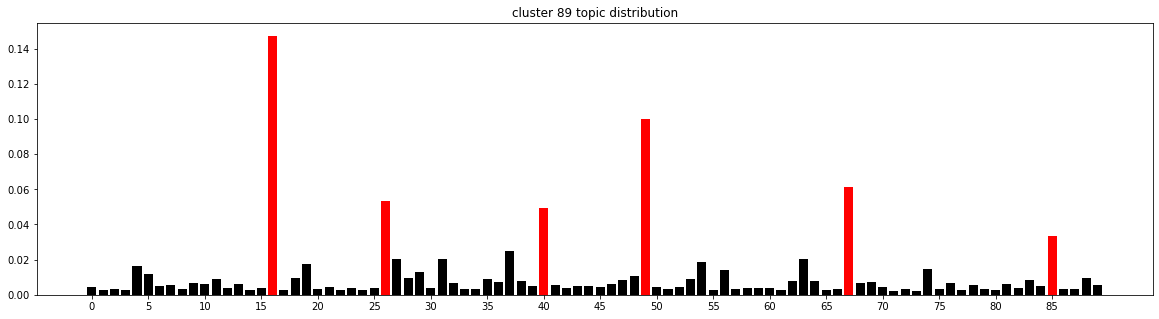

16  0.147
0.054*"city" + 0.034*"area" + 0.032*"london" + 0.027*"local" + 0.025*"region" + 0.020*"north" + 0.017*"north_east" + 0.017*"regional" + 0.013*"deal" + 0.010*"economic"

49  0.1
0.093*"local" + 0.074*"council" + 0.053*"local_authority" + 0.029*"planning" + 0.025*"community" + 0.024*"authority" + 0.023*"development" + 0.021*"area" + 0.020*"plan" + 0.012*"site"

67  0.061
0.061*"money" + 0.055*"funding" + 0.054*"million" + 0.038*"fund" + 0.037*"billion" + 0.034*"spend" + 0.033*"budget" + 0.021*"cost" + 0.019*"spending" + 0.019*"increase"

26  0.054
0.065*"cut" + 0.014*"face" + 0.012*"lose" + 0.012*"poor" + 0.012*"fail" + 0.011*"bad" + 0.011*"budget" + 0.011*"impact" + 0.010*"real" + 0.009*"million"

40  0.049
0.031*"area" + 0.030*"rural" + 0.028*"constituency" + 0.019*"community" + 0.017*"broadband" + 0.015*"rural_area" + 0.015*"service" + 0.011*"cornwall" + 0.011*"constituent" + 0.010*"access"

85  0.033
0.071*"tax" + 0.051*"rate" + 0.028*"increase" + 0.023*"pay" + 0.017*"measu

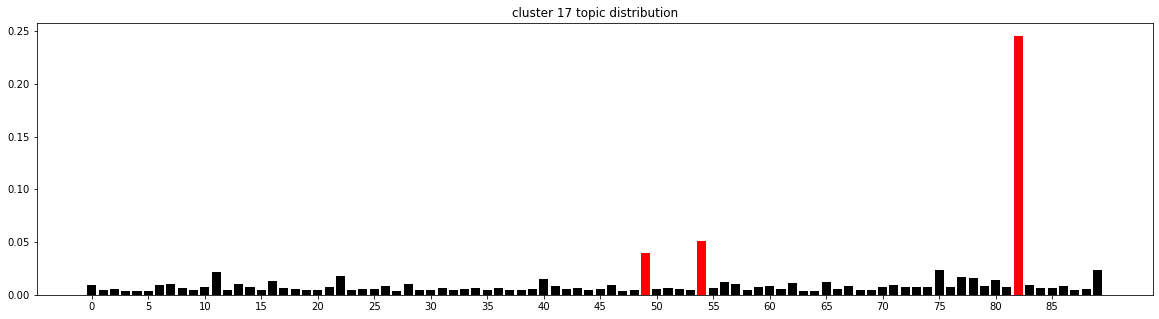

82  0.245
0.041*"petition" + 0.020*"recall" + 0.020*"urge" + 0.019*"constituent" + 0.017*"sign" + 0.017*"state" + 0.017*"commons" + 0.016*"mr" + 0.013*"john" + 0.011*"constituency"

54  0.051
0.040*"local" + 0.029*"constituency" + 0.027*"community" + 0.023*"centre" + 0.017*"town" + 0.017*"close" + 0.015*"closure" + 0.014*"area" + 0.014*"shop" + 0.013*"business"

49  0.04
0.093*"local" + 0.074*"council" + 0.053*"local_authority" + 0.029*"planning" + 0.025*"community" + 0.024*"authority" + 0.023*"development" + 0.021*"area" + 0.020*"plan" + 0.012*"site"

top tfidf words: petition petition_resident petitioners declares petitioner_request petitioners_request petitioners_remain_etc petitioner_remain_etc petitioner present_petition

size: 620
centroid: [-2.024492  -3.0512362]




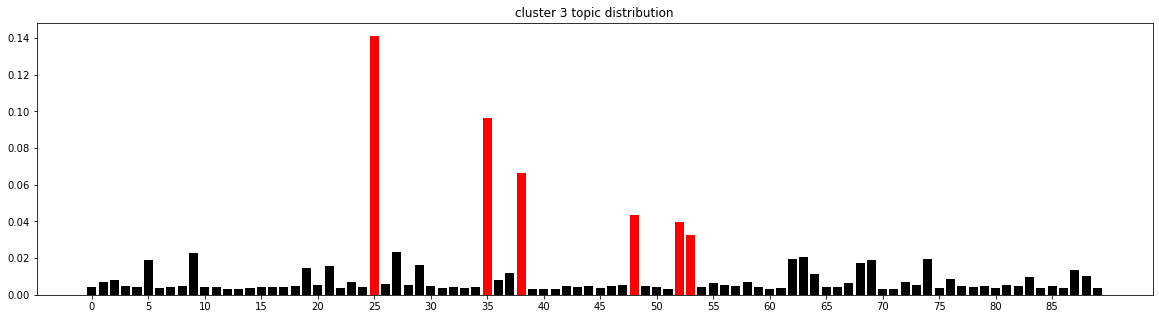

25  0.141
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

35  0.097
0.073*"parliament" + 0.017*"lords" + 0.016*"power" + 0.014*"vote" + 0.014*"elect" + 0.014*"place" + 0.013*"reform" + 0.013*"party" + 0.012*"constitutional" + 0.012*"change"

38  0.066
0.104*"committee" + 0.064*"report" + 0.027*"commission" + 0.023*"recommendation" + 0.018*"select_committee" + 0.016*"chair" + 0.012*"public" + 0.011*"parliament" + 0.011*"evidence" + 0.010*"role"

48  0.044
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

52  0.04
0.020*"staff" + 0.018*"case" + 0.015*"complaint" + 0.012*"system" + 0.011*"concern" + 0.011*"place" + 0.010*"constituent" + 0.010*"report" + 0.010*"office" + 0.009*"action"

53  0.033
0.084*"prime_minister" + 0.032*"week" + 0.030*"qu

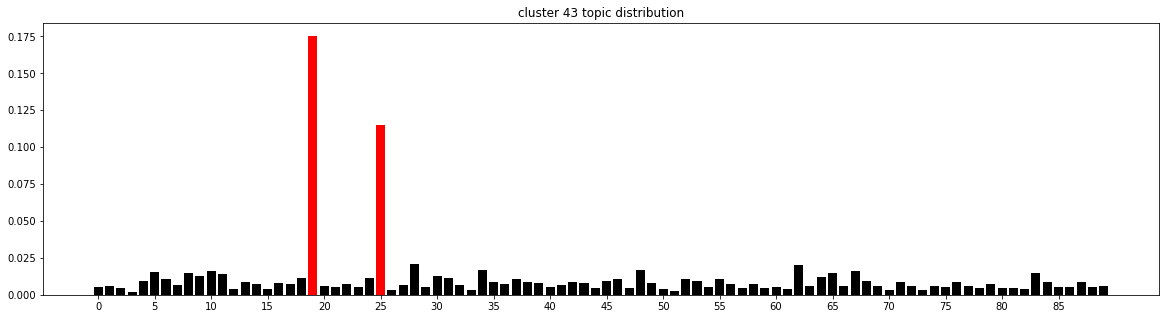

19  0.175
0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensure" + 0.028*"raise" + 0.025*"absolutely" + 0.019*"question" + 0.016*"make" + 0.016*"continue" + 0.015*"happy"

25  0.115
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

top tfidf words: adjournment_debate bills tuesday european_union_withdrawal nhs recess statutory_instrument proxy_voting knife_crime universal_credit

size: 141
centroid: [0.854197 7.924923]




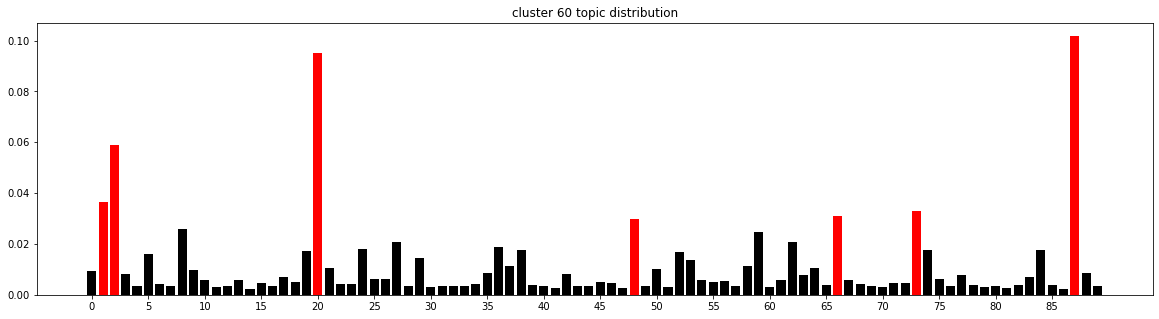

87  0.102
0.045*"inquiry" + 0.029*"report" + 0.023*"investigation" + 0.021*"evidence" + 0.013*"happen" + 0.011*"question" + 0.010*"independent" + 0.009*"case" + 0.009*"public" + 0.009*"allegation"

20  0.095
0.042*"security" + 0.015*"power" + 0.015*"terrorism" + 0.014*"threat" + 0.014*"intelligence" + 0.014*"national" + 0.013*"agency" + 0.012*"home_secretary" + 0.012*"terrorist" + 0.010*"order"

2  0.059
0.057*"court" + 0.051*"law" + 0.046*"case" + 0.024*"legal" + 0.024*"justice" + 0.013*"judge" + 0.011*"judgment" + 0.010*"rule" + 0.010*"decision" + 0.010*"system"

1  0.037
0.047*"bbc" + 0.028*"press" + 0.022*"news" + 0.022*"medium" + 0.017*"public" + 0.015*"newspaper" + 0.013*"radio" + 0.010*"journalist" + 0.009*"charter" + 0.008*"television"

73  0.033
0.039*"case" + 0.034*"offence" + 0.025*"criminal" + 0.023*"law" + 0.021*"crime" + 0.020*"court" + 0.013*"sentence" + 0.012*"act" + 0.012*"prosecution" + 0.012*"commit"

66  0.031
0.039*"datum" + 0.025*"information" + 0.025*"online" + 0

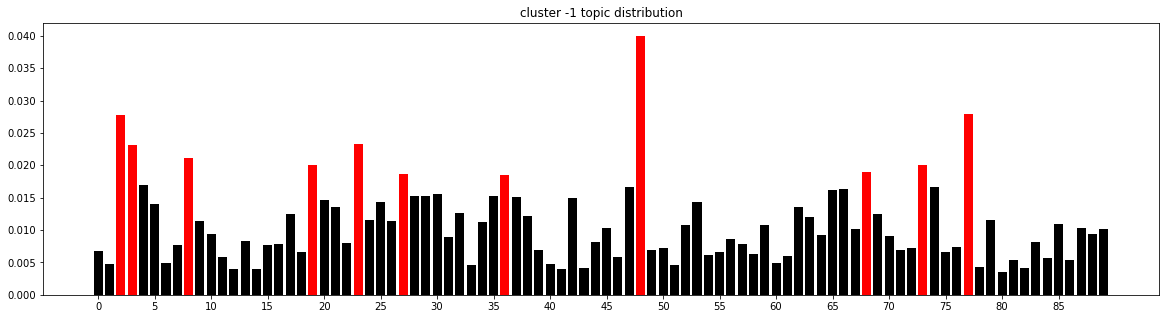

48  0.04
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

77  0.028
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

2  0.028
0.057*"court" + 0.051*"law" + 0.046*"case" + 0.024*"legal" + 0.024*"justice" + 0.013*"judge" + 0.011*"judgment" + 0.010*"rule" + 0.010*"decision" + 0.010*"system"

23  0.023
0.056*"european" + 0.038*"eu" + 0.035*"europe" + 0.028*"european_union" + 0.019*"state" + 0.017*"treaty" + 0.016*"british" + 0.013*"uk" + 0.011*"britain" + 0.011*"referendum"

3  0.023
0.015*"russia" + 0.014*"action" + 0.013*"syria" + 0.013*"iraq" + 0.012*"security" + 0.012*"military" + 0.009*"force" + 0.009*"russian" + 0.009*"nato" + 0.008*"world"

8  0.021
0.058*"family" + 0.028*"life" + 0.018*"death" + 0.017*"constituent" + 0.014

In [60]:
for cluster_id in least_coherent_cluster_ids:
    summarise_cluster(cluster_id)

In [168]:
df_cluster.sample(5)

lemmas_ngrams  \
cluster                                                      
95       [question, world_cup, wish, fabio, capello, en...   
6        [acknowledge, dangerous, certainly, misleading...   
11       [information, department, hold, effect, indust...   
92       [welcome, new, post, business, question, leade...   
1        [constituent, nottingham_east, pakistani, kash...   

                                                topic_dist  size   entropy  \
cluster                                                                      
95       [0.004490550118949197, 0.009349597962200664, 0...   415  5.199355   
6        [0.003875544497758349, 0.0037149236129084555, ...  1082  5.011546   
11       [0.0044843754562806535, 0.0038652623092560916,...   275  5.069700   
92       [0.007793854937065592, 0.0041018909793681165, ...   544  5.411609   
1        [0.005248891057567305, 0.0071239864714664, 0.0...    61  4.710940   

             I_eff                                        tfidf_words  
cluster                                                                
95       36.741928  sport football ticket club game fa rugby fan l...  
6        32.257134  academy pupil teacher teaching curriculum gcse...  
11       33.583959  airport heathrow apd aviation runway flight pa...  
92       42.565391  animal dog food farmer animal_welfare puppy ci...  
1        26.189928  kashmir pakistan india kashmiri indian jammu k...

## cluster timeseries

In [ ]:
def plot_cluster_freq(df, i_list, use_top_word=False):
    for i in i_list:
        label = i
        df[df.cluster == i].reset_index().set_index('date').resample('M').agg('count').rename(columns={'heading':label})[label].plot()

In [ ]:
plot_cluster_freq(df_f, [58, 59])